In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary


def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

a=6371.0e3
R=a

In [15]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m50      =(glob.glob('/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_0.5x_solar/*.hkl'))
m5       =(glob.glob('/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/*.hkl'))
# HC10_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC10_la50m_oc5m/*.hkl'))
# HC20_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC20_la50m_oc5m/*.hkl'))
# HC30_50_5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC30_la50m_oc5m/*.hkl'))

# HC10_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC10_la5m_oc50m/*.hkl'))
# HC20_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC20_la5m_oc50m/*.hkl'))
# HC30_5_50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC30_la5m_oc50m/*.hkl'))


In [16]:
m5

['/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/flux_interp_dict.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/mmc_decompose_vert_interp.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/raw_data_dict.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/flux_vert_interp_dict.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/coord_dic.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/div_flux_dict.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/div_vert_interp_dict.hkl',
 '/project2/tas1/pragallva/Winter_quarter_2019/post_process_data/sst1_1.0x_solar/mmc_decompose_interp.hkl']

In [18]:
DEPTHS=[m5, m50]
flux=[]
flux_vert=[]
div=[]
div_vert=[]
# eke=[]
raw=[]
tsurf=[]
mmc_decomp=[]
mmc_decomp_vert=[]
c=4
coord=load(m5[c])
for depth in DEPTHS:
    f=0; mmcv=1; r=2; fv=3; c=4; d=5; dv=6; mmc=7 
#     f=0; e=1; mmcv=2; r=3; fv=4; c=5; d=6; dv=7; mmc=8;
    raw.append(load(depth[r]))
    mmc_decomp.append(load(depth[mmc]))
    flux.append(load(depth[f]))
    flux_vert.append(load(depth[fv]))
    div.append(load(depth[d])) 
    div_vert.append(load(depth[dv]))
#     eke.append(load(depth[e]))
    mmc_decomp.append(load(depth[mmc]))
    mmc_decomp_vert.append(load(depth[mmcv]))
    mmc_decomp.append(load(depth[mmc]))

In [6]:
# def save(X,name): 
#     Y={'d5':X[d5], 'd10':X[d10],'d50':X[d50], 'd100':X[d100]}
#     sio.savemat(name, Y)
# dest= '/project2/tas1/pragallva/Summer_quarter_2018/MAT_files/'  
# make_sure_path_exists(dest)
# save(flux,dest+"Isca_depths_FLUX_in_PW.mat")
# save(div, dest+"Isca_depths_DIV_in_W_m2.mat")
# save(raw, dest+"Isca_depths_RAW_data_all_levels.mat")
# sio.savemat(dest+"coordinates.mat", coord)

In [19]:
raw[0].keys()

['Z', 'q', 'U', 'T', 'V', 'MSE', 'latn']

In [20]:
lat=div[0]['latn']
def M(X):
    #X=X-X.mean(axis=0)[None,:]
    return X
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]; precip=[]
for depth in range(len(DEPTHS)):
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up
    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))
    precip.append(M(flux[depth]['precip']))
    
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

In [21]:
TE=[]; MM=[]; SE=[]; INE=[]; EKE_vert=[]; EMF_vert=[]; del_m_mmc=[]; del_v_mmc=[]
del_m_mmc_vert=[]; del_v_mmc_vert=[]
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
    INE.append(TE[depth]+SE[depth]+MM[depth])

for depths_a in range(len(DEPTHS)):
     del_m_mmc.append(M(mmc_decomp[depths_a]['del_m_mmc']))
     del_v_mmc.append(M(mmc_decomp[depths_a]['del_v_mmc']))
     del_m_mmc_vert.append(M(mmc_decomp_vert[depths_a]['del_m_mmc']))
     del_v_mmc_vert.append(M(mmc_decomp_vert[depths_a]['del_v_mmc']))
    

In [22]:
def M(X):
    return np.array(X)
del_m_mmc=M(del_m_mmc); del_v_mmc=M(del_v_mmc);
del_m_mmc_vert=M(del_m_mmc_vert); del_v_mmc_vert=M(del_v_mmc_vert);

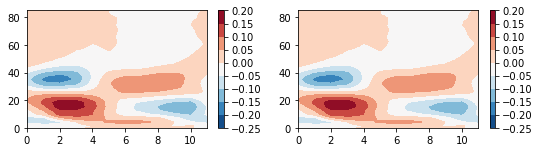

In [25]:
py.figure(figsize=(15,4))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    py.contourf(range(12),lat,del_m_mmc[d,...],  cmap=BuRd);py.colorbar()
    py.ylim(0,85)
    
py.tight_layout()

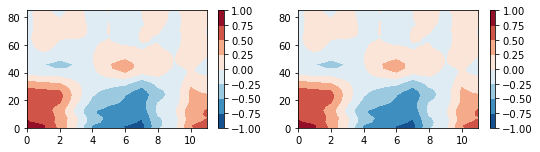

In [26]:
py.figure(figsize=(15,4))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    py.contourf(range(12),lat,del_v_mmc[d,...],  cmap=BuRd);py.colorbar()
    py.ylim(0,85)
py.tight_layout()

In [27]:
# py.figure(figsize=(15,4))
# i=0; 
# for d in range(len(DEPTHS)):
#     py.subplot(2,4,d+1)
#     py.contourf(range(13),lat_a,(MM_a-MM_a.mean(axis=-1)[...,None])[d,...], vmin=-10, vmax= 10, cmap=BuRd);
#     py.colorbar()
#     py.ylim(0,85)
# py.tight_layout()

In [28]:
# py.figure(figsize=(15,4))
# for d in range(len(DEPTHS)):
#     py.subplot(2,4,d+1)
#     py.contourf(range(12),lat,(del_m_mmc+del_v_mmc)[d,...], vmin=-20, vmax= 20, cmap=BuRd);py.colorbar()
#     py.ylim(0,85)
    
# py.tight_layout()

In [29]:
import scipy.integrate as integrate
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    #int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:])#int_x_r[:-1,:]) #int_x[::-1,:][1:,:]+
    return avg_int_r/10**15

In [30]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[];
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])
    

In [31]:
# d=3
# py.plot(swabs[d][:].mean(axis=1)-swabs[d].mean(),'r-')
# py.plot(shf[d][:].mean(axis=1)-shf[d].mean(),'b-')
# py.plot( -(olr[d][:].mean(axis=1)-olr[d].mean()),'g-')
# py.plot(dhdt[d][:].mean(axis=1)-dhdt[d].mean(),'k-')
# py.plot(ne[d][:].mean(axis=1)-ne[d].mean(),'m-')

# Average Northern and Southern Hemispheres

In [32]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE); EKE_vert=np.array(EKE_vert); EMF_vert=np.array(EMF_vert)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);
ISFC=np.array(ISFC); ITOA=np.array(ITOA); TS=np.array(TS)
# mmc_decomp=np.array(mmc_decomp)

In [33]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:]+flux_flag*np.roll(x[:,l_S,:][:,::-1,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[:,:,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [34]:
#      del_m_mmc.append(M(mmc_decomp[depths_a]['del_m_mmc']))
#      del_v_mmc.append(M(mmc_decomp[depths_a]['del_v_mmc']))
#      del_m_mmc_vert.append(M(mmc_decomp_vert[depths_a]['del_m_mmc']))
#      del_v_mmc_vert.append(M(mmc_decomp_vert[depths_a]['del_v_mmc']))

In [35]:
TE_a   ,SE_a     , MM_a  , NE_a  , NE_a,   lat_a  = N_S_avg(TE, SE, MM, NE, NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a = N_S_avg( ISFC,ISFC,ISFC,ISFC,ISFC, lat[1:-1] )[0]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]
del_m_mmc_a   ,del_v_mmc_a , del_m_mmc_a   ,del_v_mmc_a  , del_v_mmc_a,   lat_a  = N_S_avg(del_m_mmc,del_v_mmc,del_m_mmc,del_v_mmc,del_v_mmc,lat)


In [36]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a

(-60, 60)

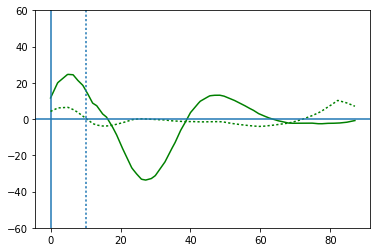

In [38]:
field=div_MM_a
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]

for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'g'+str(ls[d-4]),lw=1.5)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]))
py.axhline(0)
py.ylim(-60,60)

(-60, 60)

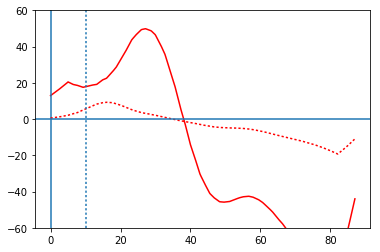

In [39]:
field=div_TE_a
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]

for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'r'+str(ls[d-4]),lw=1.5)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]))
py.axhline(0)
py.ylim(-60,60)

(-60, 60)

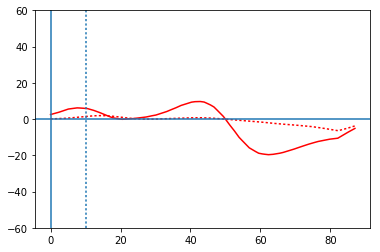

In [40]:
field=div_SE_a
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]

for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'r'+str(ls[d-4]),lw=1.5)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]))
py.axhline(0)
py.ylim(-60,60)

In [41]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

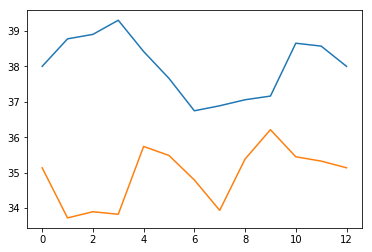

In [44]:
py.plot(storm_pos[0,:])
py.plot(storm_pos[1,:])

In [45]:
div_TE_a.shape

(2, 871, 13)

In [46]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    div_SE_a=spher_div(SE_a*10**15)
    div_MM_a=spher_div(MM_a*10**15)
    div_NE_a=div_TE_a+div_SE_a+div_MM_a
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [47]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [48]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)


I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)


In [49]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nan
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 1.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

## Shift decompose

In [50]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    div_SE_a=spher_div(SE_a*10**15)
    div_MM_a=spher_div(MM_a*10**15)
    div_NE_a=div_TE_a+div_SE_a+div_MM_a
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [51]:
div_NE_a.shape

(2, 871, 13)

In [52]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [53]:
def plot_flux(d,n,threshold_value,field,l=12) :
    
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    pos=zero_div_TE
    
    
#    DEPTHS_title=["5m","HC10 50 5","HC20 50 5","HC30 50 5", "50m", "HC10 5 50","HC20 5 50","HC30 5 50"]
    DEPTHS_title=["5m","HC10 50 5","5m + 50m tropics (20deg)","HC30 50 5", "50m", "HC10 5 50","50m + 5m tropics (20deg)","HC30 5 50"]
    
#     if d==0:depth=5
#     if d==1:depth=10
#     if d==2:depth=50
#     if d==3:depth=100

    mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),0)
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       y= np.roll(y,0,axis=-1)  
       return y

    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-1*l, l+1, threshold_value)
    latns=lat

    #py.subplot(2,4,n)
    py.subplot(2,2,n)
    b = py.contourf(range(13),lat_a,add(field[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),lat_a, add(field[d,...]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), np.roll((pos[d,:]),0), 'ro-')
    #py.plot(range(13), (Intensity_te[d,:]*5), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(DEPTHS_title[d]),fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,80)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

(2, 871, 13)


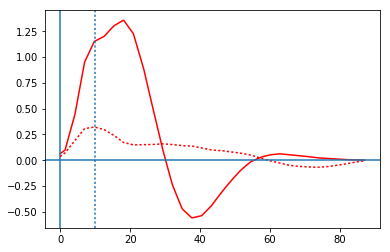

In [57]:
field=MM_a
# ls=[':','--','-.','-'] # 10,20,30
# trop_edge=[10,20,30,0,10,20,30,0]

# for d in range(4):
#     py.plot(lat_a,field[d,...].mean(axis=-1),'b'+str(ls[d]),lw=1.5)
#     py.axvline(trop_edge[d],linestyle=str(ls[d]))
# # for d in range(4,8):
# #     py.plot(lat_a,field[d,...].mean(axis=-1),'b'+str(ls[d-4]),lw=1.5)
# py.axhline(0)

ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0, 10,20,30,0,10,20,30]

for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'r'+str(ls[d-4]),lw=1.5)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]))
py.axhline(0)
print MM_a.shape

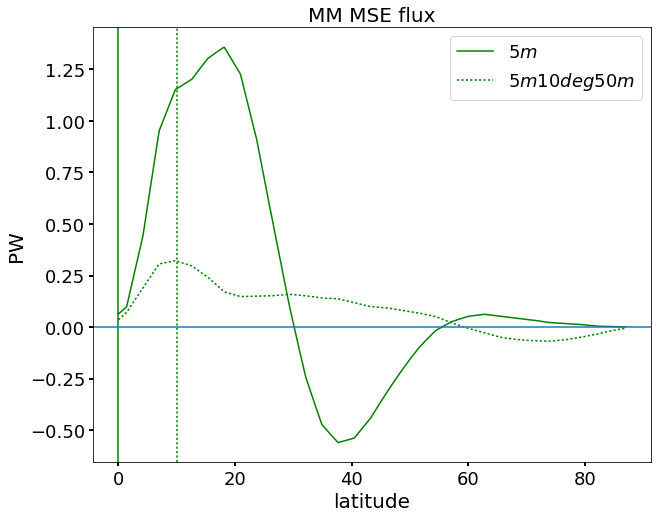

In [56]:
ls=['-',':','--','-.'] # 10,20,30
labels=['5m','5m 10deg50m','5m 20deg50m','5m 30deg50m', '50m','50m 10deg5m','50m 20deg5m','50m 30deg5m']
trop_edge=[0, 10,20,30,0,10,20,30]
field=MM_a
fig=py.figure(figsize=(10, 8))
for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'g'+str(ls[d-4]),label=r'$'+str(labels[d])+'$',lw=1.5)
    py.legend(loc='best',fontsize=18)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]),c='g')
py.axhline(0)
py.tick_params(labelsize=18,size=4,width=2)
py.ylabel("PW",fontsize=20)
py.xlabel("latitude",fontsize=20)
py.title("MM MSE flux",fontsize=20)


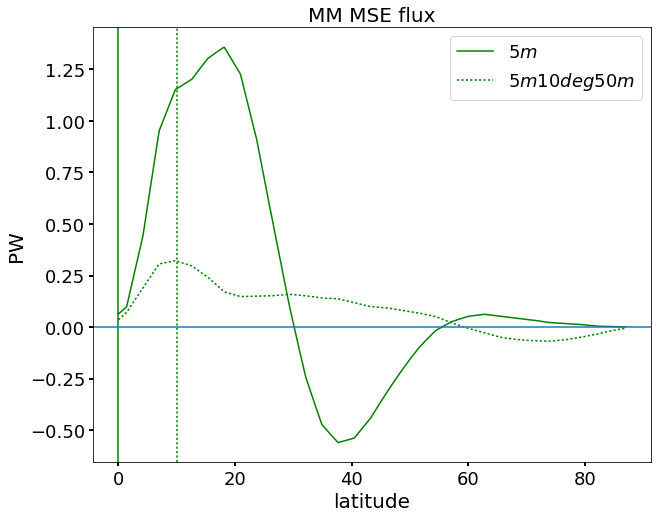

In [58]:
ls=['-',':','--','-.'] # 10,20,30
labels=['5m','5m 10deg50m','5m 20deg50m','5m 30deg50m', '50m','50m 10deg5m','50m 20deg5m','50m 30deg5m']
trop_edge=[0, 10,20,30,0,10,20,30]
field=MM_a
fig=py.figure(figsize=(10, 8))
for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'g'+str(ls[d]),label=r'$'+str(labels[d])+'$',lw=1.5)
    py.legend(loc='best',fontsize=18)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]),c='g')
py.axhline(0)
py.tick_params(labelsize=18,size=4,width=2)
py.ylabel("PW",fontsize=20)
py.xlabel("latitude",fontsize=20)
py.title("MM MSE flux",fontsize=20)

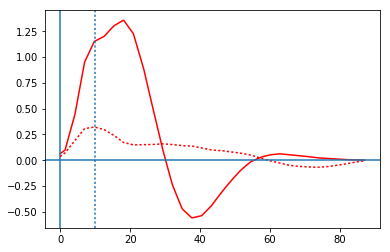

In [59]:
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0, 10,20,30,0,10,20,30]

for d in range(len(DEPTHS)):
    py.plot(lat_a,field[d,...].mean(axis=-1),'r'+str(ls[d-4]),lw=1.5)
    py.axvline(trop_edge[d],linestyle=str(ls[d-4]))
py.axhline(0)

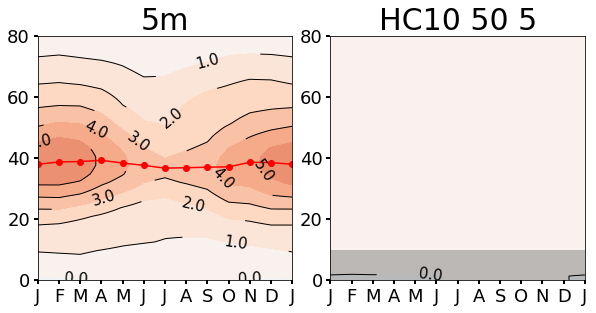

In [65]:
# plot_flux(d,n,threshold_value,field,l=12)
fig=py.figure(figsize=(10, 10))
field=TE_a
trop_edge=[0,10,20,30,0,10,20,30]
for d in range(len(DEPTHS)):
    plot_flux(d,d+1,1.0,field)
    py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)

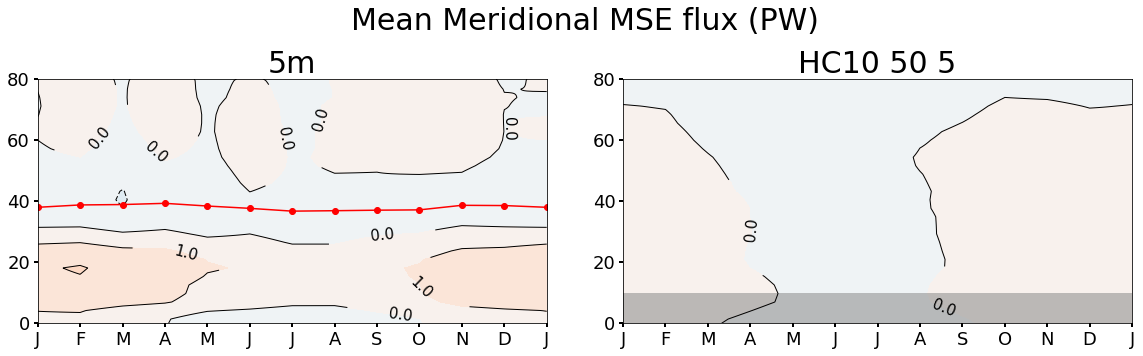

In [66]:
# plot_flux(d,n,threshold_value,field,l=12)
fig=py.figure(figsize=(20, 10))
field=MM_a
trop_edge=[0,10,20,30,0,10,20,30]
i=0
for d in range(len(DEPTHS)):
    i=i+1
    plot_flux(d,i,1.0,field)
    py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)
py.suptitle("Mean Meridional MSE flux (PW)",fontsize=30)

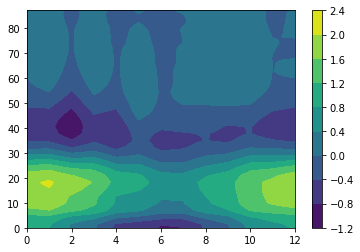

In [74]:
py.contourf(range(13), lat_a, MM_a[0,...]); py.colorbar()

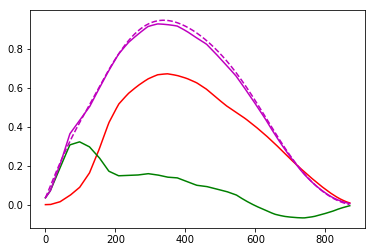

In [84]:
py.plot(TE_a[1,...].mean(axis=-1),'r-')
py.plot(MM_a[1,...].mean(axis=-1),'g-')
py.plot(NE_a[1,...].mean(axis=-1),'m-')
py.plot(Ine_a[1,...].mean(axis=-1),'m--')

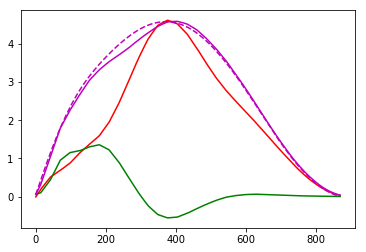

In [85]:
py.plot(TE_a[0,...].mean(axis=-1),'r-')
py.plot(MM_a[0,...].mean(axis=-1),'g-')
py.plot(NE_a[0,...].mean(axis=-1),'m-')
py.plot(Ine_a[0,...].mean(axis=-1),'m--')

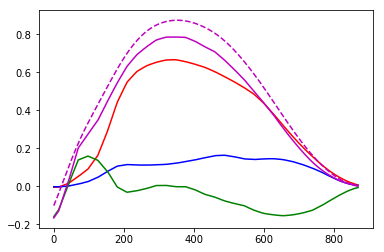

In [110]:
m=m+1
py.plot(TE_a[1,:,m],'r-')
py.plot(SE_a[1,:,m],'b-')
py.plot(MM_a[1,:,m],'g-')
py.plot(NE_a[1,:,m],'m-')
py.plot(Ine_a[1,:,m],'m--')

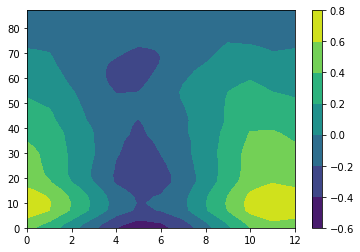

In [106]:
py.contourf(range(13),lat_a,MM_a[1,...]); py.colorbar()

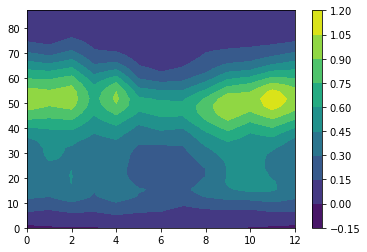

In [105]:
py.contourf(range(13),lat_a,SE_a[0,...]); py.colorbar()

In [44]:
# fig=py.figure(figsize=(40, 10))
# field=MM_a
# trop_edge=[0,10,20,30,0,10,20,30]
# for d in range(8):
#     plot_flux(d,1.0,field-field.mean(axis=-1)[...,None])
#     py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)
# #     py.ylim(20,60)


# fig=py.figure(figsize=(40, 10))
# field=+del_m_mmc_a
# trop_edge=[0,10,20,30,0,10,20,30]
# for d in range(8):
#     plot_flux(d,1.0,field,20.0)
#     py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)
# #     py.ylim(20,60)


# fig=py.figure(figsize=(40, 10))
# field=del_v_mmc_a
# trop_edge=[0,10,20,30,0,10,20,30]
# for d in range(8):
#     plot_flux(d,1.0,field,20)
#     py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)
# #     py.ylim(20,60)

In [45]:
# fig=py.figure(figsize=(40, 10))
# field=del_m_mmc_a
# trop_edge=[0,10,20,30,0,10,20,30]
# for d in range(8):
#     plot_flux(d,1.0,field)
#     py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)
# #     py.ylim(20,60)

In [149]:
# fig=py.figure(figsize=(40, 10))
# field=MM_a
# trop_edge=[0,10,20,30,0,10,20,30]
# for d in range(8):
#     plot_flux(d,1.0,field)
#     py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)

In [ ]:
fig=py.figure(figsize=(20, 10))
field=MM_a
trop_edge=[0,10,20,30,0,10,20,30]
i=0
for d in [0,2,4,6]:
    i=i+1
    py.subplot(2,2,i)
    plot_flux(d,i,1.0,field)
    py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)

In [ ]:
fig=py.figure(figsize=(40, 10))
field=MM_a
trop_edge=[0,10,20,30,0,10,20,30]
for d in range(8):
    plot_flux(d,1.0,field)
    py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)

In [ ]:
fig=py.figure(figsize=(40, 10))
field=TE_a
trop_edge=[0,10,20,30,0,10,20,30]
for d in range(8):
    plot_flux(d,1.0,field)
    py.axhspan(0,trop_edge[d],facecolor='0.5', alpha=0.5)

# Storm track shift 

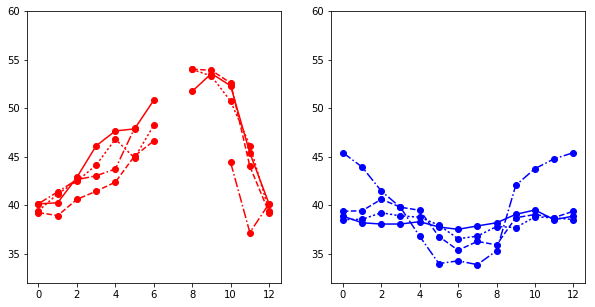

In [47]:
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[10,20,30,0,10,20,30,0]
py.figure(figsize=(10,5))
py.subplot(1,2,1)
for d in range(4):
    py.plot(range(13),zero_div_TE[d,...],'ro'+str(ls[d]),lw=1.5)
    py.ylim(32,60)
py.subplot(1,2,2)
for d in range(4,8):
    py.plot(range(13),zero_div_TE[d,...],'bo'+str(ls[d-4]),lw=1.5)
    py.ylim(32,60)


In [48]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=1,threshold_value=+1,return_value=0) :
        
    DEPTHS_title=["5m", "HC10 50 5","HC20 50 5","HC30 50 5", "50m", "HC10 5 50","HC20 5 50","HC30 5 50"]
    I=Intensity_te    
    n=d+1    
#     month_to_month=1
#     threshold_value=0
    SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    if d==0:
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))
    else :
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    
    if ((d==0) & (month_to_month==0)):
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,38,8), find_zero(NE_change))
    
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
#     fig=py.figure(figsize=(15, 9))
    
    
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=np.squeeze(find_zero(s))
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
#         print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    SE_pos             = add_month_to_end(zero_div_SE[d,1:]-base_pos)
    MM_pos             = add_month_to_end(zero_div_MM[d,1:]-base_pos)
    NE_pos             = add_month_to_end(zero_div_NE[d,1:]-base_pos)
    TE_calc_pos        = SE_pos+MM_pos+NE_pos
    nonlinear_error    = TE_obs_pos-TE_calc_pos        
#     py.subplot(220+n)
    py.subplot(2,4,n)
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=20)
    fig=py.plot(SE_pos,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(MM_pos,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(NE_pos,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
#     print TE_obs_pos.shape
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    if ((d==0) or (d==4)) :
       py.ylabel("deg \\ poleward", fontsize=40)

    title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp"+"_"+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=30,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    if d==0:
        py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    if return_value==1:
        return TE_obs_pos, SE_pos, MM_pos, NE_pos, nonlinear_error
   
    

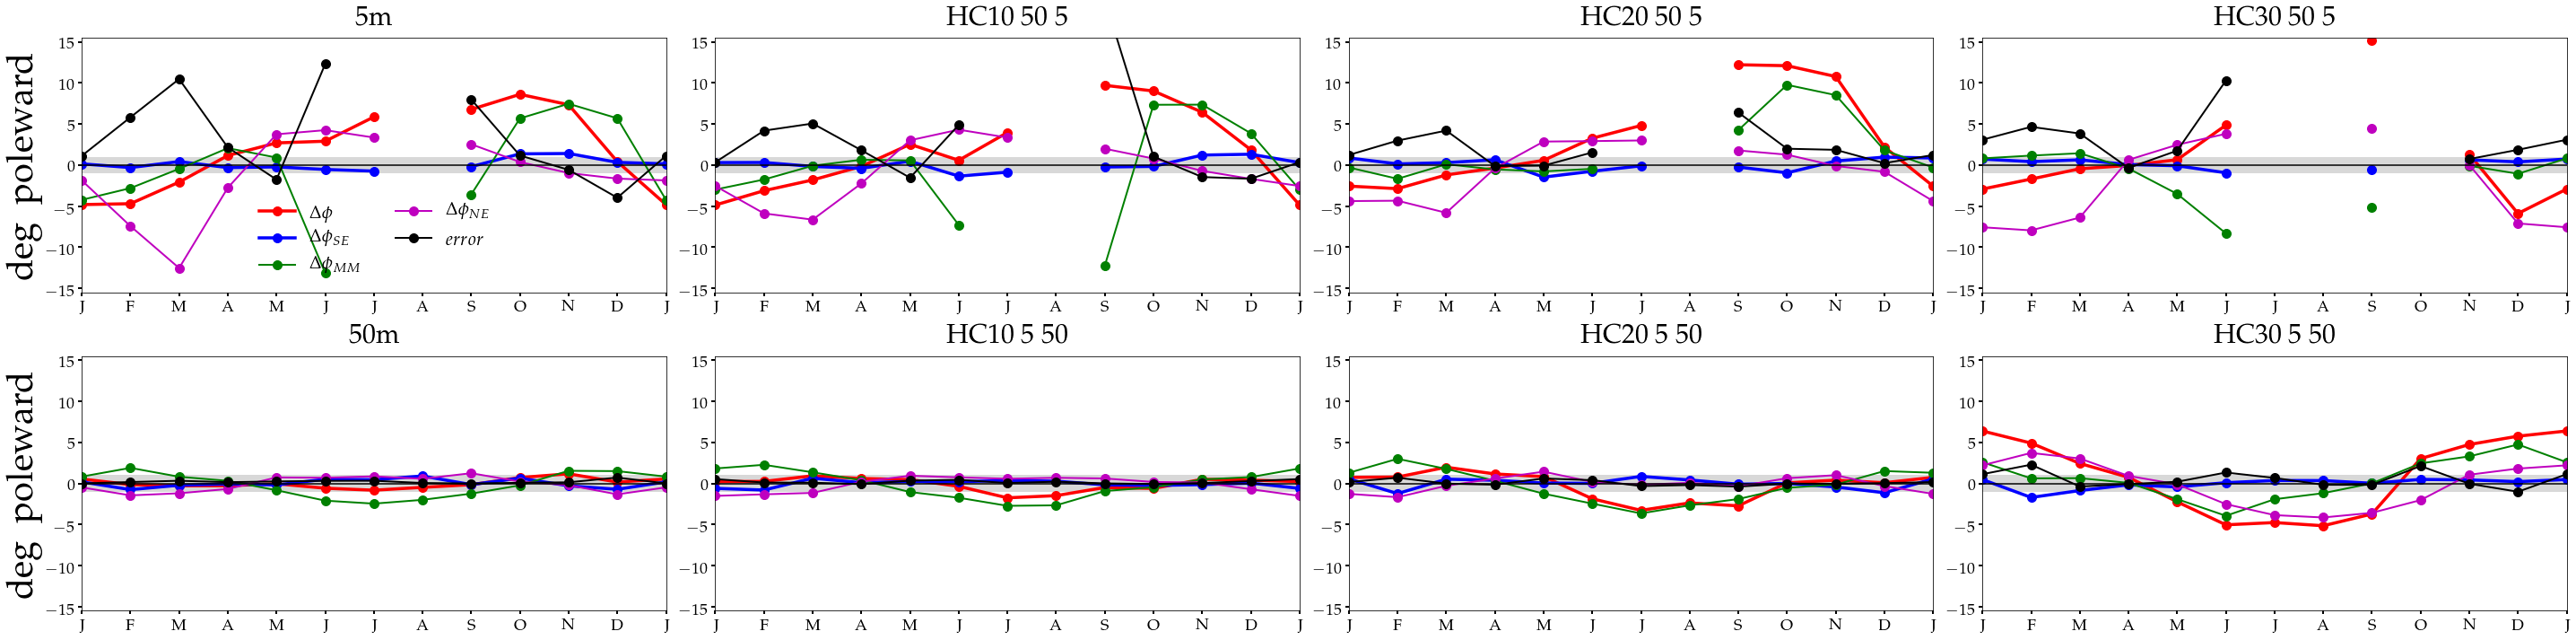

In [49]:
te_pos= np.zeros((8,13)); se_pos=np.copy(te_pos); mm_pos=np.copy(te_pos); ne_pos=np.copy(te_pos); nerr=np.copy(te_pos)
fig=py.figure(figsize=(40, 10))
for d in range(8):
    l=15.5
    month_to_month=0; threshold_value=+0.9
    te_pos[d,:], se_pos[d,:], mm_pos[d,:], ne_pos[d,:], nerr[d,:] =plot_monthly_shift(d,l,month_to_month,threshold_value,1)
py.tight_layout()

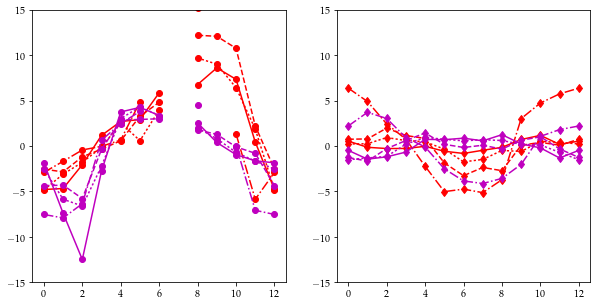

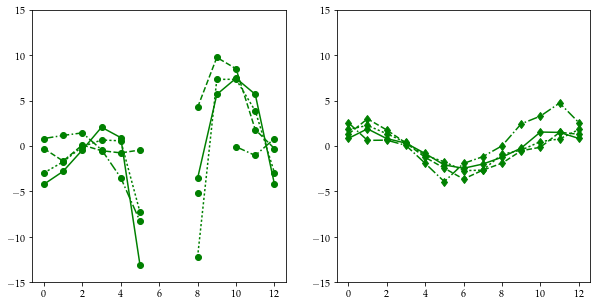

In [50]:
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]
py.figure(figsize=(10,5))
py.subplot(1,2,1)
for d in range(4):
    py.plot(range(13),te_pos[d,...],'ro'+str(ls[d]),lw=1.5)
    py.ylim(-15,15)
py.subplot(1,2,2)
for d in range(4,8):
    py.plot(range(13),te_pos[d,...],'rd'+str(ls[d-4]),lw=1.5)
    py.ylim(-15,15)
    
    
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]
# py.figure(figsize=(10,5))

py.subplot(1,2,1)
for d in range(4):
    py.plot(range(13),ne_pos[d,...],'mo'+str(ls[d]),lw=1.5)
    py.ylim(-15,15)
py.subplot(1,2,2)
for d in range(4,8):
    py.plot(range(13),ne_pos[d,...],'md'+str(ls[d-4]),lw=1.5)
    py.ylim(-15,15)
    
    
ls=['-',':','--','-.'] # 10,20,30
trop_edge=[0,10,20,30,0,10,20,30]
py.figure(figsize=(10,5))

py.subplot(1,2,1)
for d in range(4):
    py.plot(range(13),mm_pos[d,...],'go'+str(ls[d]),lw=1.5)
    py.ylim(-15,15)
py.subplot(1,2,2)
for d in range(4,8):
    py.plot(range(13),mm_pos[d,...],'gd'+str(ls[d-4]),lw=1.5)
    py.ylim(-15,15)
    


In [51]:
# plot_monthly_shift(0,16.5,month_to_month=0,threshold_value=1)

# Intensity decomposition

In [52]:
### radiation

def plot_intensity(d,l,month_to_month=1):
    
    DEPTHS_title=["5m","HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m", "HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
           
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=3.5)
    py.plot(D(Intensity_ne,d),'mo-',label=r'$\Delta I_{NE}$',lw=3.5)   
    py.plot(-D(Intensity_se,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=3.5)
    py.plot(-D(Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=3.5)
                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    title1="Intensity_decomposition_"+"_"+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=44,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
#     py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    if d==0:
        py.legend(loc='best',fontsize=32,ncol=2,frameon=False)
    #py.savefig(fig_dest+title1+'.pdf')
    #print fig_dest+title1+'.pdf'

    
#     py.tight_layout()

In [53]:
Intensity_te.shape

(8, 13)

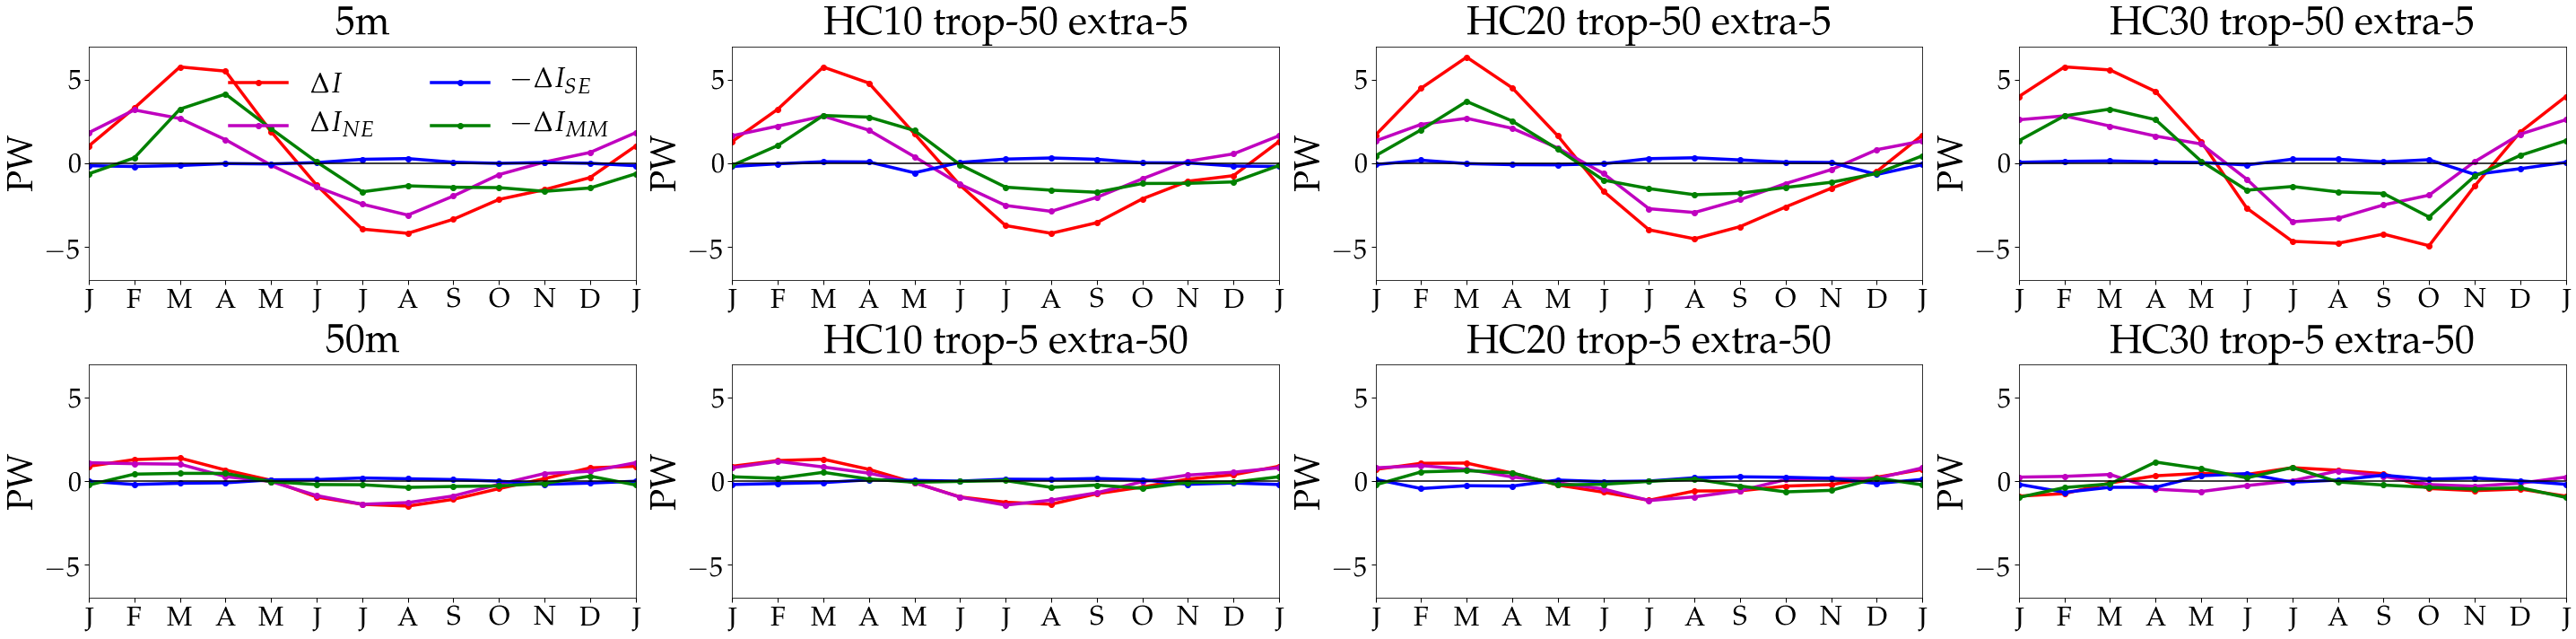

In [54]:
l=7; i=0;
fig=py.figure(figsize=(40, 10))
for d in range(8):
    py.subplot(2,4,i+1)
#     if d>3 :
#         l=2
    plot_intensity(d,l,0)
    i=i+1
    py.tight_layout()

In [55]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_delta_NE(d,l,month_to_month=1):
    
    DEPTHS_title=["5m","HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m", "HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    

    def D(y,d):
        if month_to_month==1 :
            y1=y
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            #mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            #mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
            
#     fig=py.figure(figsize=(10, 6))           
    py.plot(D(I_NE,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB,d),'co-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(I_SHF,d),'bo-',label=r'$\Delta I_{SHF}$',lw=3.5)
    py.plot(D(-I_OLR,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=3.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+""+str(depth)+"m"
    title1="NE_decomposition_"+"_"+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=32,ncol=2,frameon=False, loc='best')

    
    #py.savefig(fig_dest+title1+'.pdf')
    #print fig_dest+title1+'.pdf'    
    py.tight_layout()

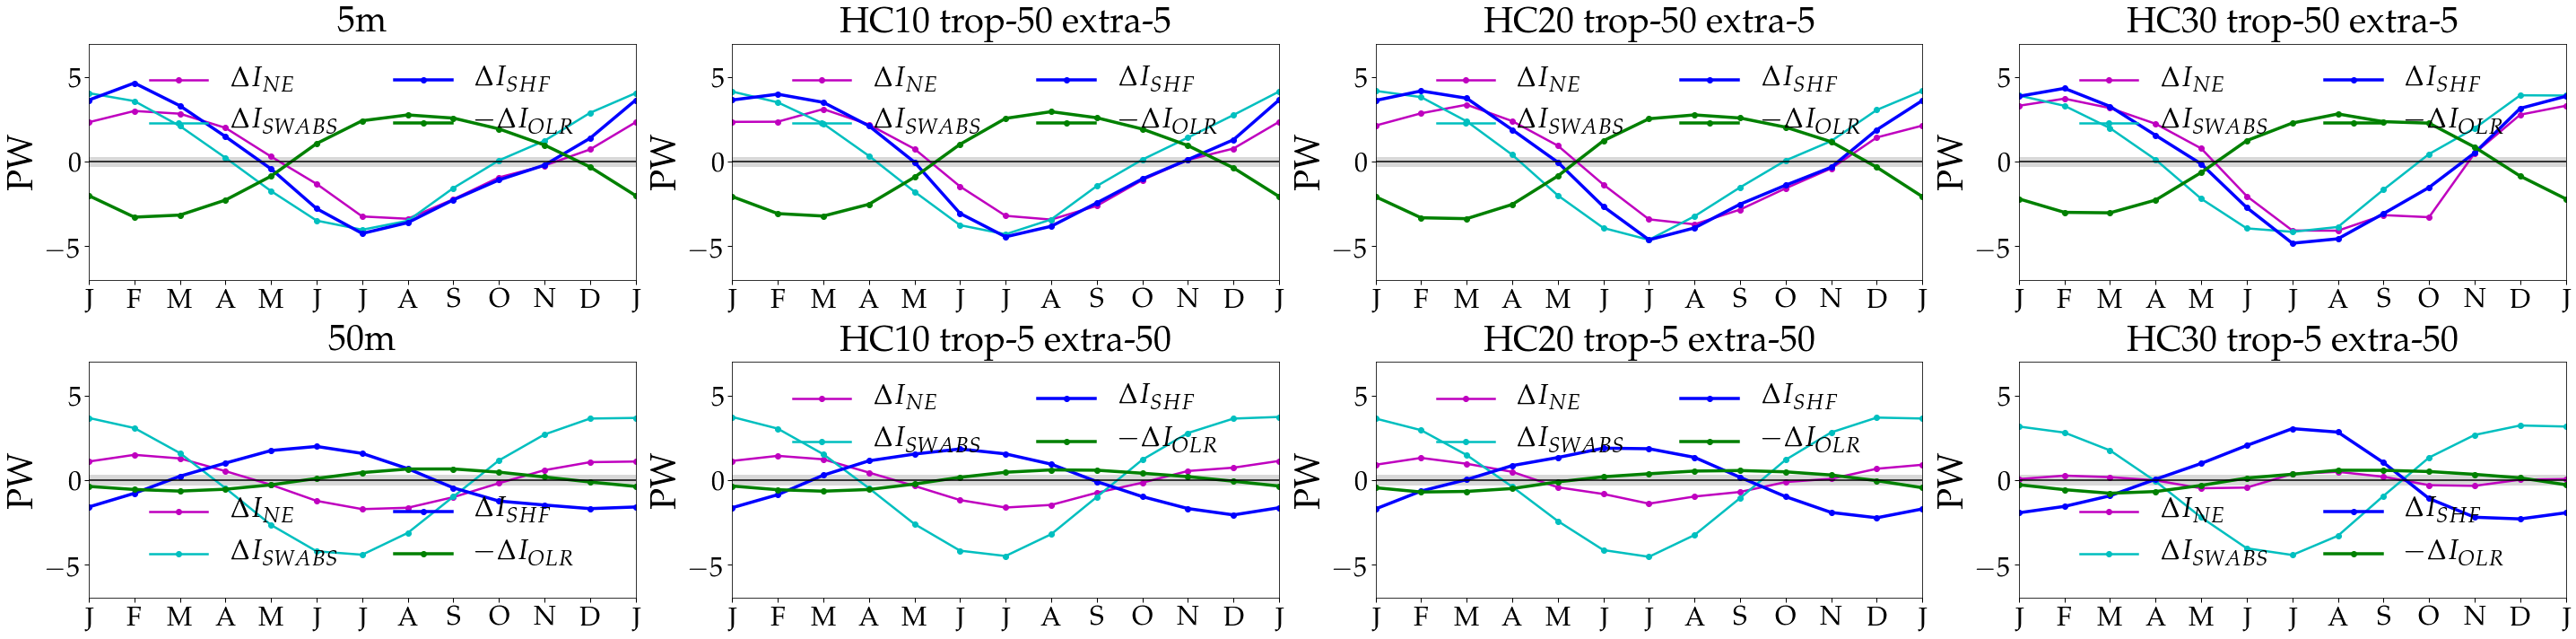

In [56]:
l=7; i=0;
fig=py.figure(figsize=(40, 10))
for d in range(8):
    py.subplot(2,4,i+1)
    plot_delta_NE(d,l,0)
    i=i+1

In [123]:
def compare_plot(n,X,c,T,month_to_month=1,l=3,d=0):
    #py.subplot(1,2,n)
    py.subplot(220+n)
#     py.subplot(3,1,n)
#     py.subplot(4,1,n)    
    #DEPTHS_title=["5m","HC10 50 5","HC20 50 5","HC30 50 5", "50m", "HC10 5 50","HC20 5 50","HC30 5 50"]
    DEPTHS_title=["5m"," ","5m + 50m tropics (20deg)"," ", "50m", " ","50m + 5m tropics (20deg)",""]
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    py.plot(range(13),D(X[d,:]),c+'o-'   ,label=str(DEPTHS_title[d+0]),lw=2.5)             
#    py.plot(range(13),D(X[d+3,:]),c+'o-.' ,label=str(DEPTHS_title[d+3]),lw=2.5)
    py.plot(range(13),D(X[d+2,:]),c+'o--',label=str(DEPTHS_title[d+2]),lw=2.5)
#    py.plot(range(13),D(X[d+1,:]),c+'o:',label=str(DEPTHS_title[d+1]),lw=2.5)

       
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=35)
    #if n==1:
    py.legend(loc='best',fontsize=32,ncol=2,frameon=False)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=48)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)


# fig=py.figure(figsize=(22, 15))
# compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$')
# compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$')
# compare_plot(3,-I_OLR,'g',r'$ - \Delta I_{OLR}$')
# compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$')


In [124]:
# fig=py.figure(figsize=(30, 20))
# compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',month_to_month=0,l=8)
# compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',month_to_month=0,l=8)
# compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',month_to_month=0,l=8)
# compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',month_to_month=0,l=8)

In [125]:
# fig=py.figure(figsize=(30, 20))
# compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',month_to_month=0,l=8,d=4)
# compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',month_to_month=0,l=8,d=4)
# compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',month_to_month=0,l=8,d=4)
# compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',month_to_month=0,l=8,d=4)

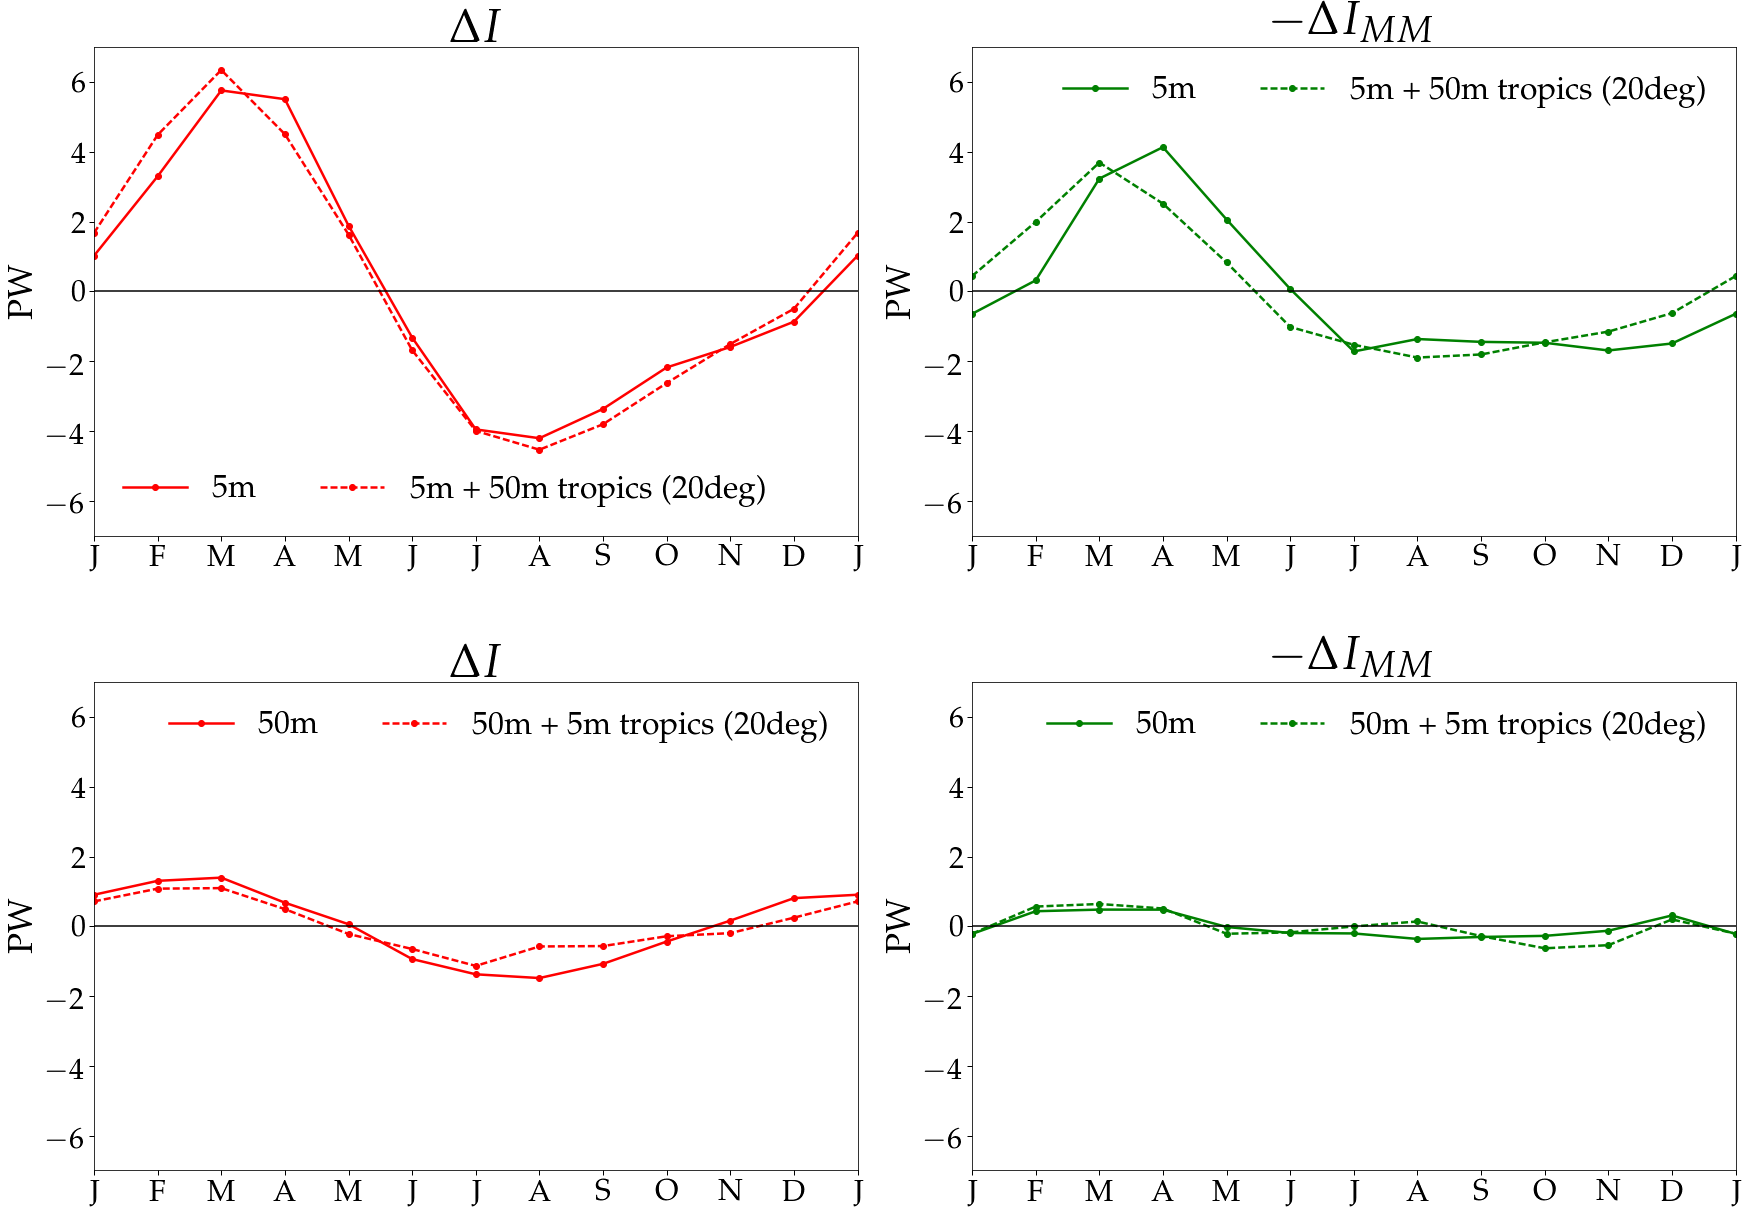

In [129]:
fig=py.figure(figsize=(30, 20))
compare_plot(1,Intensity_te,'r',r'$\Delta I$',month_to_month=0,l=7)
compare_plot(2,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',month_to_month=0,l=7)
compare_plot(3,Intensity_te,'r',r'$\Delta I$',month_to_month=0,l=7,d=4)
compare_plot(4,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',month_to_month=0,l=7,d=4)

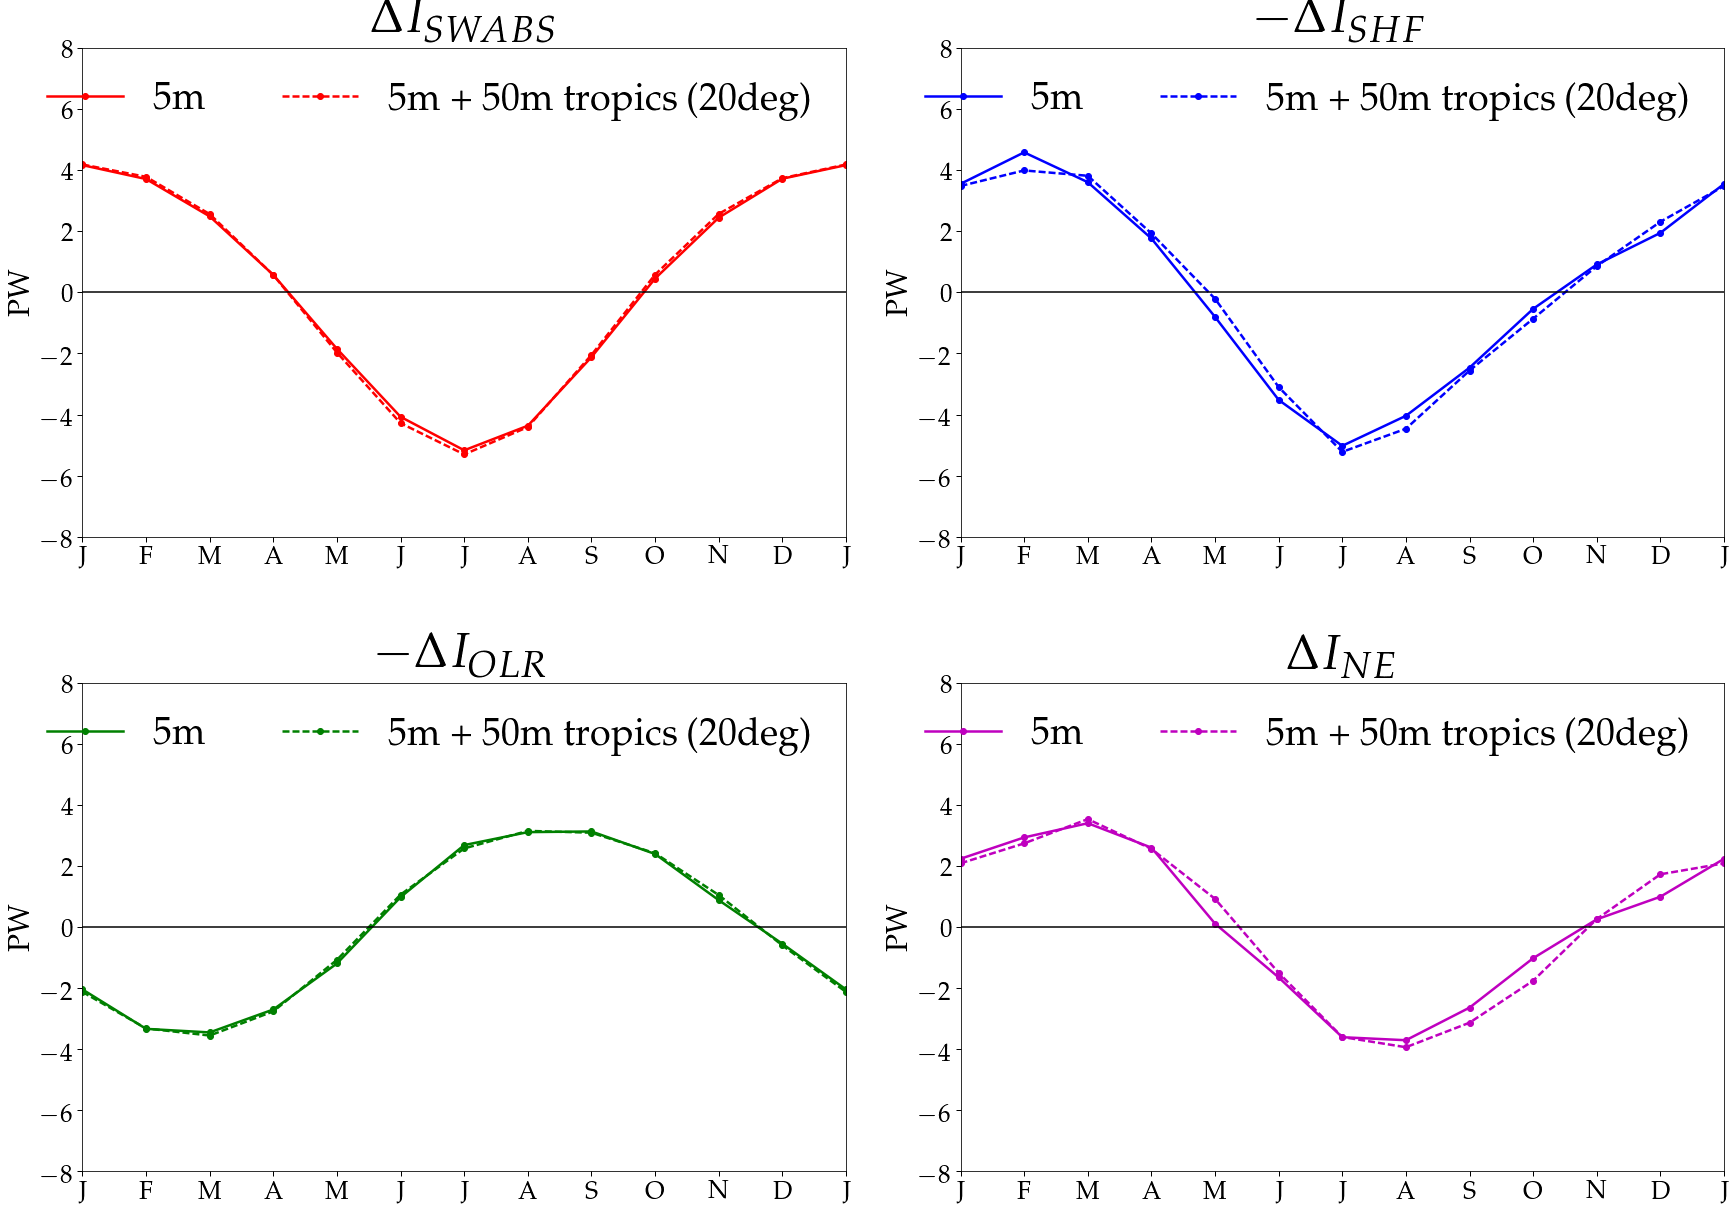

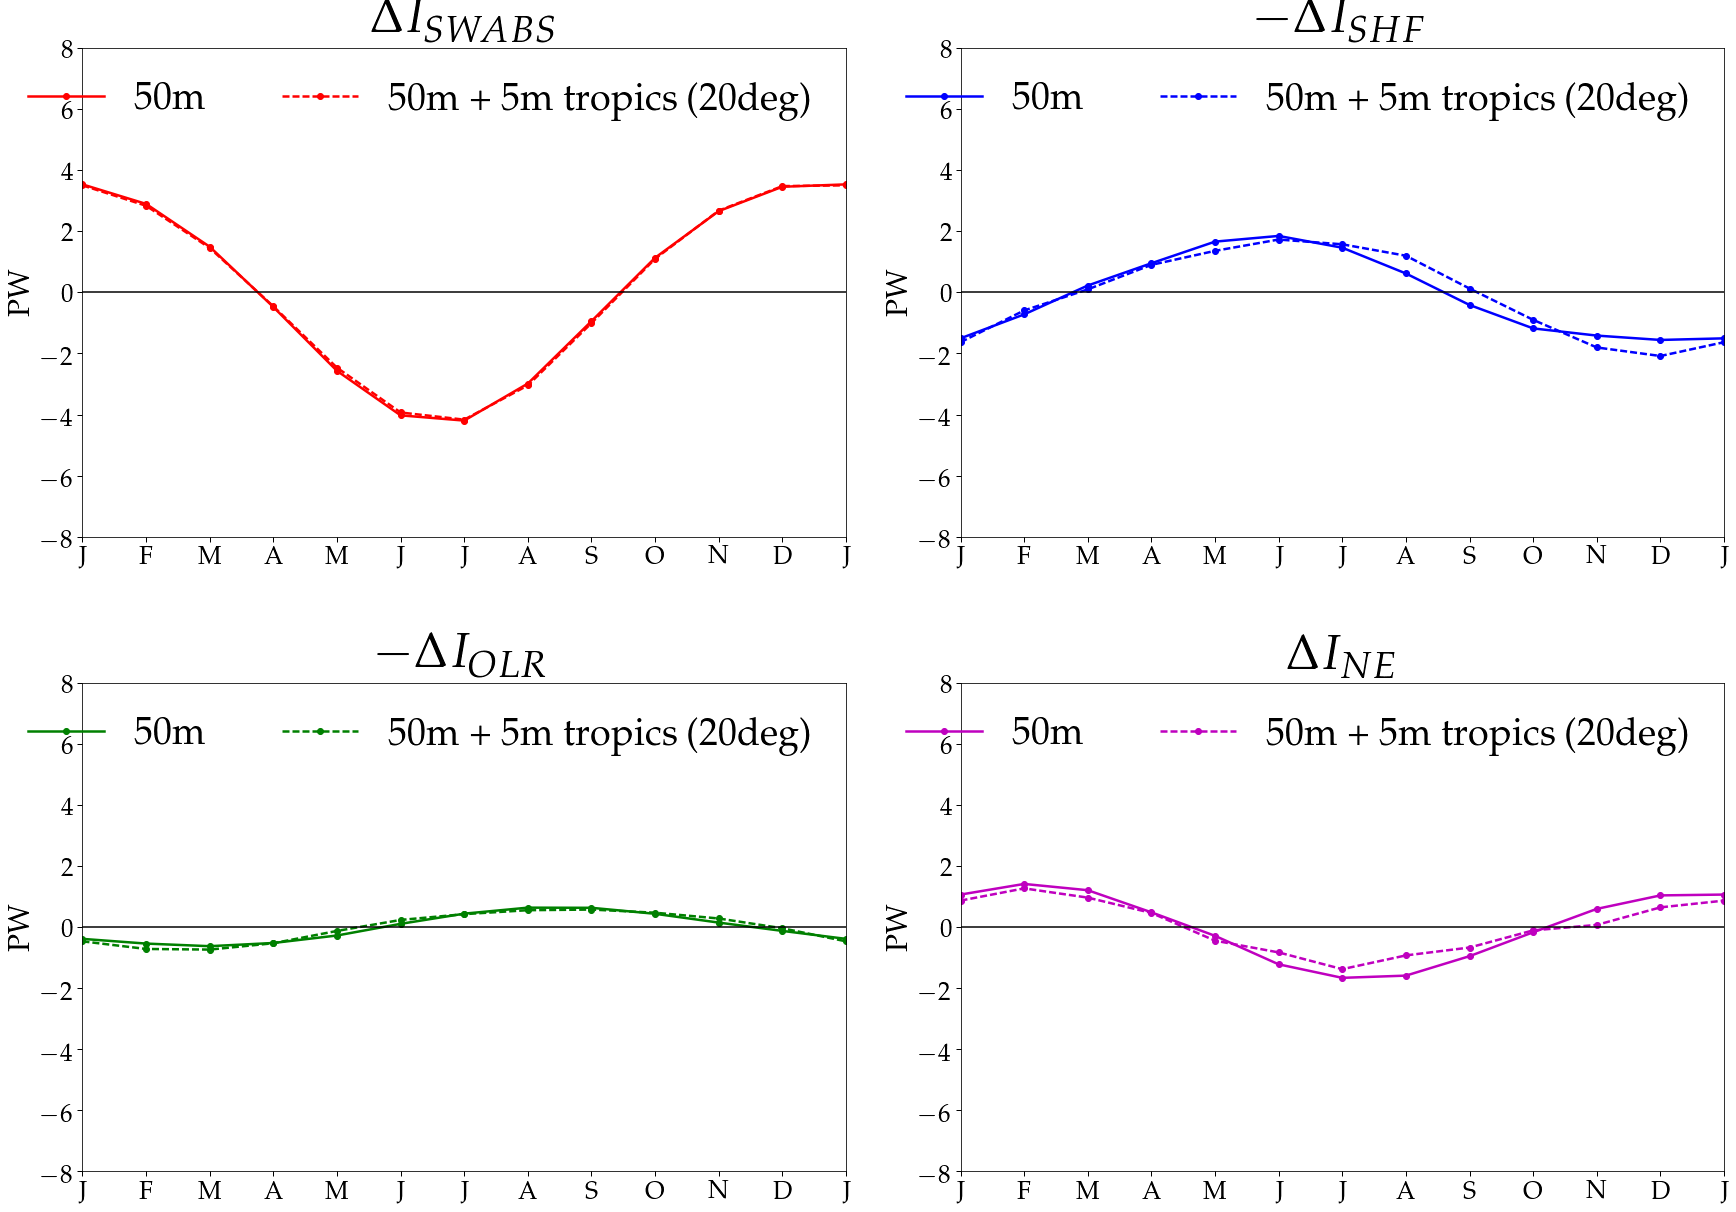

In [114]:
fig=py.figure(figsize=(30, 20))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$',month_to_month=0,l=8)
compare_plot(2,I_SHF,'b',r'$ - \Delta I_{SHF}$',month_to_month=0,l=8)
compare_plot(3,-I_OLR,'g',r'$ - \Delta I_{OLR}$',month_to_month=0,l=8)
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$',month_to_month=0,l=8)

fig=py.figure(figsize=(30, 20))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$',month_to_month=0,l=8,d=4)
compare_plot(2,I_SHF,'b',r'$ - \Delta I_{SHF}$',month_to_month=0,l=8,d=4)
compare_plot(3,-I_OLR,'g',r'$ - \Delta I_{OLR}$',month_to_month=0,l=8,d=4)
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$',month_to_month=0,l=8,d=4)

In [61]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=40
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D


I_SWAB_at40 =inerp_at_max(Iswabs_a,latr_a)
I_SHF_at40  =inerp_at_max(Ishf_a,latr_a)
I_NE_at40   =inerp_at_max(Ine_a,latr_a)
I_OLR_at40  =inerp_at_max(Iolr_a,latr_a)
I_dhdt_at40 =inerp_at_max(Idhdt_a,latr_a)

In [62]:
# m_to_m=0; l=8
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,I_SWAB_at40,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
# compare_plot(2,I_SHF_at40,'b',r'$\Delta I_{SHF}$',m_to_m,l)
# compare_plot(3,-I_OLR_at40,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
# compare_plot(4,I_NE_at40,'m',r'$\Delta I_{NE}$',m_to_m,l)

# Decompose Net energy in Watts/m^2

In [63]:
swabs=np.array(swabs); shf=np.array(shf); ne=np.array(ne); olr=np.array(olr); dhdt=np.array(dhdt);
SW_sfc=np.array(SW_sfc); LW_sfc=np.array(LW_sfc); SW_toa=np.array(SW_toa); shflx=np.array(shflx); lhflx=np.array(lhflx);
sfc=np.array(sfc); toa=np.array(toa); 

In [64]:
#     swabs.append(div[depth]['SWABS'])
#     shf.append(div[depth]['SHF'])
#     dhdt.append(div[depth]['dhdt'])
#     olr.append(div[depth]['olr'])
#     ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
#     SW_sfc.append(-1*div[depth]['SW_sfc_d'])
#     LW_sfc.append(-1*div[depth]['LW_sfc_d'])
#     SW_toa.append(div[depth]['SW_toa_d'])
#     shflx.append(div[depth]['shflx_u'])
#     lhflx.append(div[depth]['lhflx_u'])

In [65]:
SWABS_a, SHF_a  , NE_a , OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#

SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]


In [66]:
def inerp_at_mean(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=np.nanmean(zero_div_TE[d,:-1])
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [67]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

In [68]:
P_SWAB =inerp_at_max(SWABS_a,lat_a)
P_SHF  =inerp_at_max(SHF_a,lat_a)
P_NE   =inerp_at_max(NE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

P_SWsfc = inerp_at_max(SW_sfc_a,lat_a)
P_LWsfc = inerp_at_max(LW_sfc_a,lat_a)
P_SWtoa = inerp_at_max(SW_toa_a,lat_a)
P_shflx = inerp_at_max(shflx_a,lat_a)
P_lhflx = inerp_at_max(lhflx_a,lat_a)

P_sfc = inerp_at_max(sfc_a,lat_a)
P_toa = inerp_at_max(toa_a,lat_a)

In [69]:
# def D(y):
#         y1=y[:]-y[:-1,None].mean(axis=0)
#         x2=y1
#         return x2
 
# m_to_m=0; l=8
# d=0; c1='k'
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,I_NE,'m',r'$-\Delta I_{NE}$',m_to_m,l)
# # py.plot(range(13),D(-I_dhdt[d,:]),c1+'o-',label='5m')
# # py.plot(range(13),D(-I_dhdt[d+1,:]),c1+'o--',label='10m')
# # py.plot(range(13),D(-I_dhdt[d+2,:]),c1+'o-.',label='50m')
# # py.plot(range(13),D(-I_dhdt[d+3,:]),c1+'o:',label='100m')


In [70]:
def compare_sfc_toa_dhdt(n,X,c,T,month_to_month=1,l=3,d=0):
    
#     py.subplot(1,3,n)
    py.subplot(4,1,n)
    
    DEPTHS_title=["5m","HC10 50 5","HC20 50 5","HC30 50 5", "50m", "HC10 5 50","HC20 5 50","HC30 5 50"]
                
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
            
    py.plot(range(13),D(X[d+3,:]),c+'o-.' ,label=str(DEPTHS_title[d+3]),lw=2.5)
    py.plot(range(13),D(X[d+2,:]),c+'o--',label=str(DEPTHS_title[d+2]),lw=2.5)
    py.plot(range(13),D(X[d+1,:]),c+'o:',label=str(DEPTHS_title[d+1]),lw=2.5)
    py.plot(range(13),D(X[d,:]),c+'o-'   ,label=str(DEPTHS_title[d+0]),lw=2.5)
     
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(r'$Wm^{-2}$',fontsize=28)
    if n==1 :
        py.legend(loc='lower right',fontsize=26,ncol=2,frameon=False)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=35)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=25,size=5,width=1)
    py.xlim(0,12)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    
    

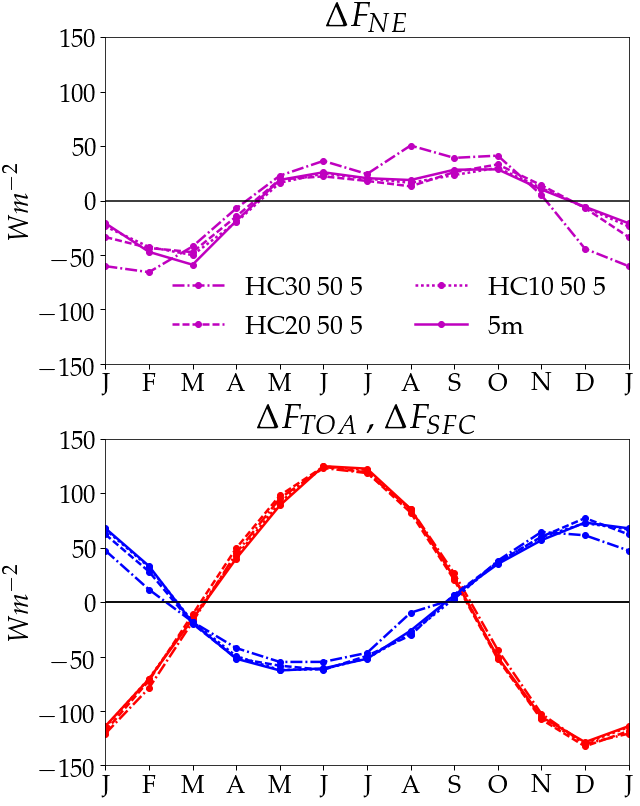

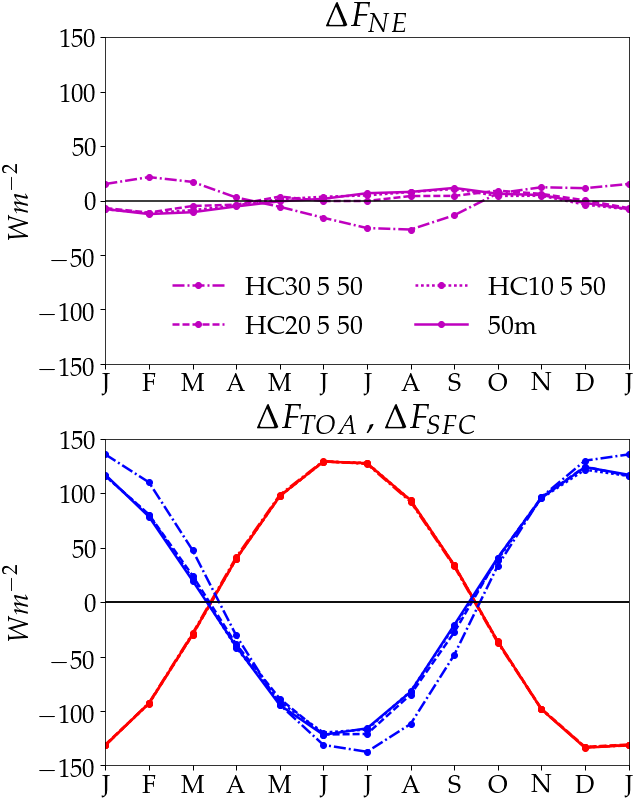

In [71]:
m_to_m=0; l=150
fig=py.figure(figsize=(9, 22))
compare_sfc_toa_dhdt(1,P_NE,'m',r'$\Delta F_{NE}$',m_to_m,l,d=0)
compare_sfc_toa_dhdt(2,P_toa,'r',' ',m_to_m,l,d=0)
compare_sfc_toa_dhdt(2,P_sfc,'b',r'$\Delta F_{TOA}$ ,   '+r'$\Delta F_{SFC}$' ,m_to_m,l,d=0)
py.tight_layout()

m_to_m=0; l=150
fig=py.figure(figsize=(9, 22))
compare_sfc_toa_dhdt(1,P_NE,'m',r'$\Delta F_{NE}$',m_to_m,l,d=4)
compare_sfc_toa_dhdt(2,P_toa,'r',' ',m_to_m,l,d=4)
compare_sfc_toa_dhdt(2,P_sfc,'b',r'$\Delta F_{TOA}$ ,   '+r'$\Delta F_{SFC}$' ,m_to_m,l,d=4)
py.tight_layout()

In [72]:
# m_to_m=0; l=6
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,I_lhflx,'r',r'$\Delta I_{lhfx}$',m_to_m,l)
# compare_plot(2,I_shflx,'b',r'$\Delta I_{shflx}$',m_to_m,l)
# compare_plot(3,I_LWsfc,'g',r'$ \Delta I_{LW\:sfc}$',m_to_m,l)
# compare_plot(4,I_SWsfc,'m',r'$\Delta I_{SW\:sfc}$',m_to_m,l)

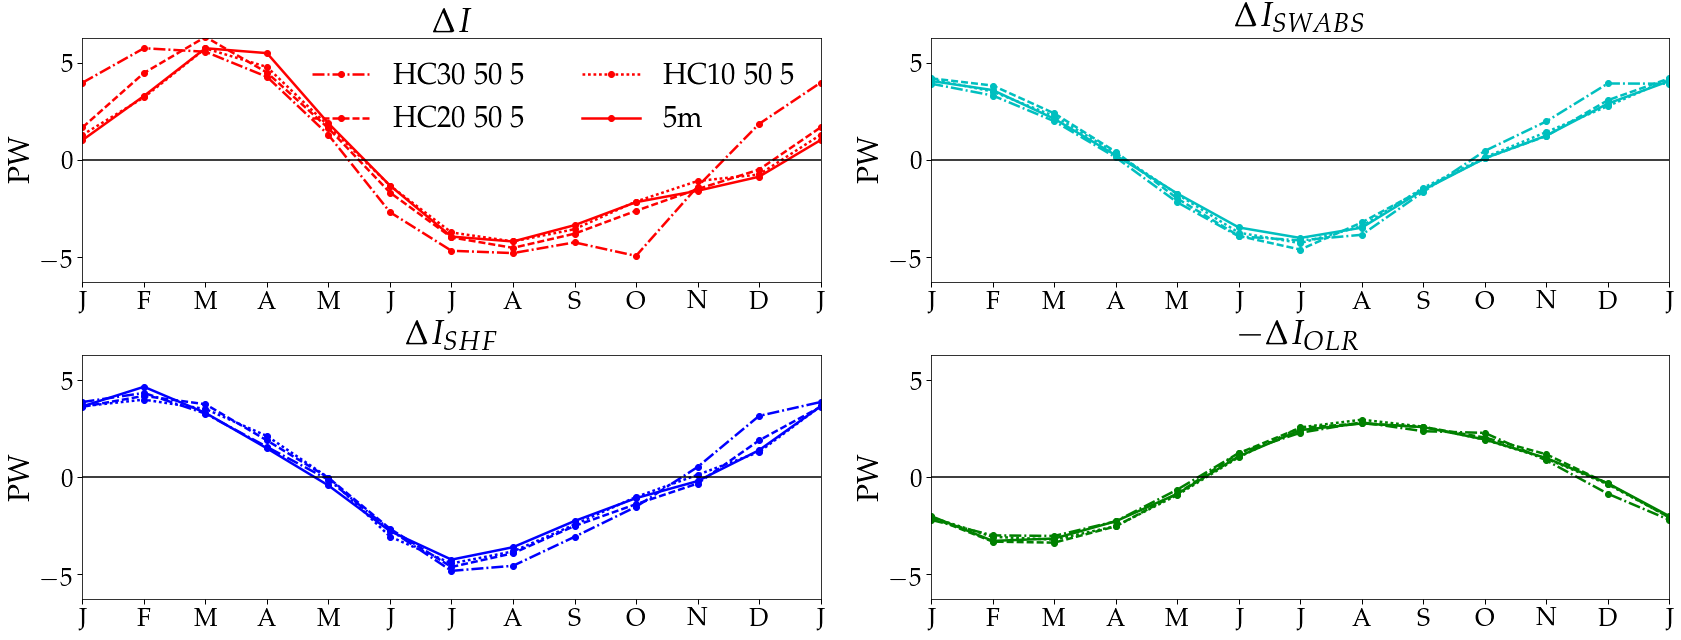

In [73]:
m_to_m=0; l=6.3
fig=py.figure(figsize=(29, 10))
compare_plot(1,Intensity_te,'r',r'$\Delta I$',m_to_m,l)
compare_plot(2,I_SWAB,'c',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(3,I_SHF,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(4,-I_OLR,'g',r'$-\Delta I_{OLR}$',m_to_m,l)


# compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$')
# compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$')
# compare_plot(3,-I_OLR,'g',r'$ - \Delta I_{OLR}$')
# compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$')


In [74]:
I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)

In [75]:
# m_to_m=0; l=90
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,P_div_TE,'r',r'$\Delta {divTE}$',m_to_m,l)
# compare_plot(2,-P_div_SE,'b',r'$-\Delta {divSE}$',m_to_m,l)
# compare_plot(3,-P_div_MM,'g',r'$-\Delta {divMM}$',m_to_m,l)
# compare_plot(4,P_div_NE,'m',r'$\Delta {NE}$',m_to_m,l)

# Predict intensity

In [76]:
### radiation

def plot_intensity(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=2.5)
    py.plot(D(Intensity_ne,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
    py.plot(-D(Intensity_se,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
    py.plot(-D(Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="Intensity decomposition"+" "+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

In [77]:
def predict_intensity(X,month_to_month=1):
    
    proxy=np.array(X); te=np.array(Intensity_te);
    
    def diff(x):
        return x[:,1:]-x[:,:-1] 
    base_pos=te[:,:-1]
    a = lambda x: np.append(x[:,-1,None],x,axis=-1)
    
    if month_to_month==0 :
      def diff(x):
         return x[:,1:]-x[:,1:,None].mean(axis=1) 
      a = lambda x: np.append(x[:,-1,None],x,axis=-1)
      base_pos=te[...,1:,None].mean(axis=1)
        
    TE_ch=base_pos+diff(te)
    predict=base_pos+diff(proxy)
        
    return a(TE_ch), a(predict)

orig, predict = predict_intensity(Intensity_ne-Intensity_mm-Intensity_se,month_to_month=0)

In [78]:
# d=0
# py.plot(orig[d,:]-orig[d,:].mean(axis=-1),'r-')
# py.plot(predict[d,:]-predict[d,:].mean(axis=-1),'r--')



In [79]:
I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)

In [80]:
# m_to_m=0; l=15
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,storm,'r','Storm  track  shift'+ r'$  \:(\Delta {\phi})$',m_to_m,l)
# py.ylabel('deg poleward')

In [81]:
zero_div_TE[0,...]

array([40.13724757, 40.24397561, 42.87449496, 46.10789865, 47.64570815,
       47.85311666, 50.80796636,         nan, 51.72295477, 53.55813694,
       52.29769549, 45.37307832, 40.13724757])

In [82]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=1,threshold_value=+1) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
            
    I=Intensity_te
    
    n=d+1    
#     month_to_month=1
#     threshold_value=0
    SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    if d==0:
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))
    else :
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    
    if ((d==0) & (month_to_month==0)):
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,38,8), find_zero(NE_change))
    
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))
    
    print zero_div_TE[0,...]
    
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=find_zero(s)
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    SE_pos             = add_month_to_end(zero_div_SE[d,1:]-base_pos)
    MM_pos             = add_month_to_end(zero_div_MM[d,1:]-base_pos)
    NE_pos             = add_month_to_end(zero_div_NE[d,1:]-base_pos)
    TE_calc_pos        = SE_pos+MM_pos+NE_pos
    nonlinear_error= TE_obs_pos-TE_calc_pos
        
#     py.subplot(220+n)
    
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=12)
    fig=py.plot(SE_pos,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=12)
    fig=py.plot(MM_pos,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=3.5,markersize=12)
    fig=py.plot(NE_pos,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=3.5,markersize=12)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=3.5,markersize=12)
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)

    title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()
    return zero_div_TE

[40.13724757 40.24397561 42.87449496 46.10789865 47.64570815 47.85311666
 50.80796636 48.79528688 51.72295477 53.55813694 52.29769549 45.37307832
 40.13724757]
[[41.78979212]]


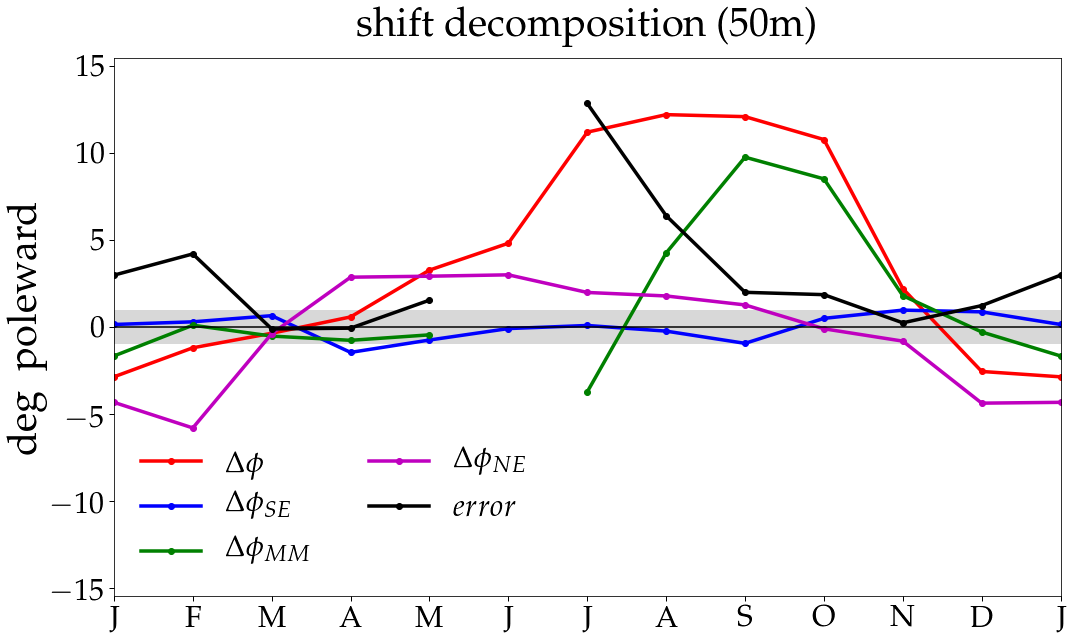

In [83]:
l=15.5
month_to_month=0; threshold_value=+0.0
storm=plot_monthly_shift(2,l,month_to_month,threshold_value)

In [84]:
# py.figure(figsize=(15,7))
# v=np.linspace(-60,60,30)
# for d in range(4):
#     py.subplot(2,2,d+1)
#     py.title(str(depths[d])+'m',fontsize=20)
#     py.contourf(range(13),lat_a,dhdt_a[d,...],v,cmap=cm.seismic);py.colorbar()
# py.tight_layout()

In [85]:
flux_vert[0]['MM'].shape

(1741, 40, 12)

## Look at precipitation data

In [86]:
precip=M(precip)

In [87]:
precip.shape

(8, 1741, 12)

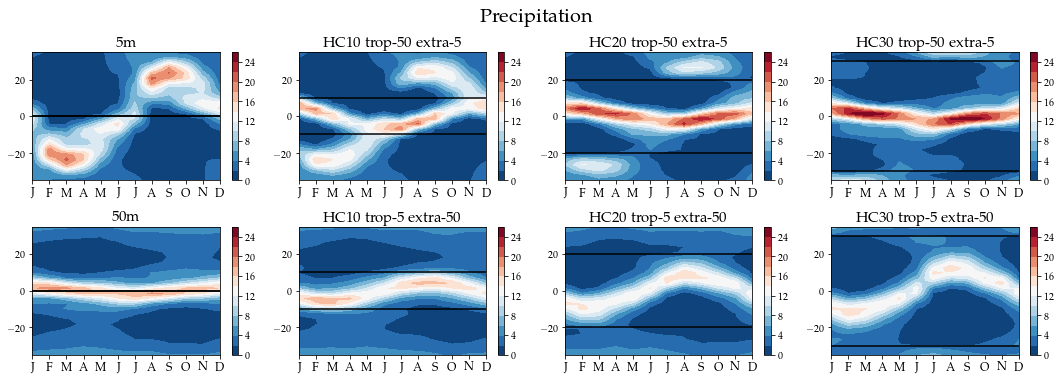

In [88]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
fig=py.figure(figsize=(15, 5))
v=np.arange(0,27,2)
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    py.contourf(range(12),lat,precip[d],v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-35,35)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Precipitation',fontsize=20,y=1.05)
py.tight_layout()

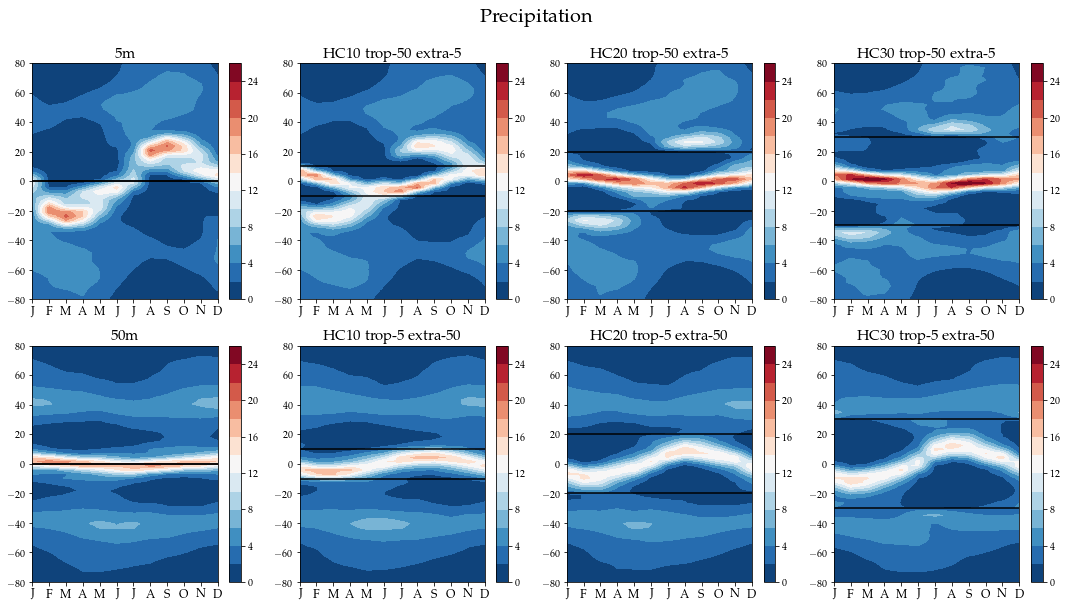

In [89]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
fig=py.figure(figsize=(15, 8))
v=np.arange(0,27,2)
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    py.contourf(range(12),lat,precip[d],v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Precipitation',fontsize=20,y=1.05)
py.tight_layout()

NameError: name 'EMF' is not defined

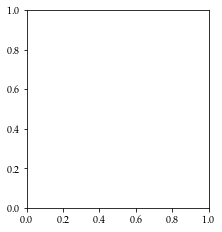

In [90]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
fig=py.figure(figsize=(15, 8))
v=np.arange(-2600, +2600+400, 400)
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d >3 :
        v=np.arange(-1000, +1000+120, 120)
    py.contourf(range(12),lat,EMF.sum(axis=2)[d,...],v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Eddy momentum flux',fontsize=20,y=1.05)
py.tight_layout()

In [ ]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
v=np.arange(-1.6e-3, +1.6e-3+2.0e-4, 2e-4)
fig=py.figure(figsize=(15, 8))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d>3:
      v=np.arange(-0.9e-3, +0.9e-3+2.0e-4, 2e-4)
    py.contourf(range(12),lat,divEMF.sum(axis=2)[d,...], v, cmap=BuRd ); py.colorbar()
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Eddy momentum flux divergence',fontsize=20,y=1.05)
py.tight_layout()



In [ ]:
v=np.arange(-1.5e-3, +1.5e-3+1.0e-4, 2e-4); v

In [ ]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
v=np.arange(-0.009, +0.009+0.001, 0.001)
fig=py.figure(figsize=(15, 8))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d>3 :
        v=np.arange(-0.003, +0.003+0.0005, 0.0005)
    py.contourf(range(12),lat,divEKE.sum(axis=2)[d,...],v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Eddy kinetic energy flux divergence',fontsize=20,y=1.05)
py.tight_layout()

In [ ]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
v=np.arange(-12, +12+2, 2)
fig=py.figure(figsize=(15, 8))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d>3 :
        v=np.arange(-6, +6+1, 1)
    py.contourf(range(12),lat,TE[d,...], v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Transient eddy MSE flux',fontsize=20,y=1.05)
py.tight_layout()

In [ ]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
v=np.arange(-240, +240+40, 40)
fig=py.figure(figsize=(15, 8))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d>3 :
        v=np.arange(-120, +120+20, 20)
    py.contourf(range(12),lat,M(div_TE)[d,...], v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Transient eddy MSE flux divergence',fontsize=20,y=1.05)
py.tight_layout()

In [ ]:
l=7; i=0;
trop_edge=[0,10,20,30,0, 10,20,30]
DEPTHS_title=["5m", "HC10 trop-50 extra-5","HC20 trop-50 extra-5","HC30 trop-50 extra-5", "50m"  ,"HC10 trop-5 extra-50","HC20 trop-5 extra-50","HC30 trop-5 extra-50"]
v=np.arange(-240, +240+40, 40)
fig=py.figure(figsize=(15, 8))
for d in range(len(DEPTHS)):
    py.subplot(2,4,d+1)
    if d>3 :
        v=np.arange(-120, +120+20, 20)
    py.contourf(range(12),lat,M(div_TE)[d,...], v, cmap=BuRd ); py.colorbar()
    i=i+1
    py.axhline(-1*trop_edge[d], color='k')
    py.axhline(trop_edge[d],color='k')
    py.ylim(-80,80)
    py.title(DEPTHS_title[d],fontsize=15)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(12),mticks,size=12)
py.suptitle('Transient eddy MSE flux divergence',fontsize=20,y=1.05)
py.tight_layout()

In [ ]:
def plot_u(d,m,t):
    v=np.arange(-60,60,10)
    if m==7:
        vemf= np.arange(-8e-5, 8e-5+1e-5, 1e-5)
    else:
        vemf= np.arange(-4e-5, 4e-5+1e-5, 1e-5)
    x=np.squeeze(raw[d]['U'][:,:,m].transpose())
    y=np.squeeze(divEMF[d,:,:,m].transpose())
    py.contour(lat, (sigma_full), x,v,colors='k'); #py.colorbar()
    py.contourf(lat, (sigma_full), y, vemf, cmap=BuRd); py.colorbar()
    py.xlim(-45,45)
    py.title(t)
    py.gca().invert_yaxis()

py.figure(figsize=(10,3))
d=0; m=5
py.subplot(1,2,1)
plot_u(d,m,'June')
d=0; m=7
py.subplot(1,2,2)
plot_u(d,m,'Aug')




In [ ]:
raw[d]['U'].shape

In [ ]:
divEKE.shape

# Look at the temperature

In [ ]:
def spher_div_for_full_field(x,fac=1):
       N=50
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(13):
            for p in range(len(sigma_full)):
              div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac),dtheta)/( R*np.cos(np.radians(lat[:])) ),N)
       return div


In [ ]:
divEMF = spher_div_for_full_field(EMF,fac=np.cos(np.radians(lat)))
divEKE = spher_div_for_full_field(EKE,fac=np.cos(np.radians(lat)))

In [ ]:
T=[]; Q=[]; U=[]; V=[]; Z=[]; EKE=[]; EMF=[];
MMv=[]; SEv=[]; NEv=[]; TEv=[];
divMMv=[]; divSEv=[]; divNEv=[]; divTEv=[];

for depth in range(len(DEPTHS)):
    T.append(M(raw[depth]['T']))
    Q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    V.append(M(raw[depth]['V']))
    Z.append(M(raw[depth]['Z']))
    EKE.append(M(eke[depth]['EKE']))
    EMF.append(M(eke[depth]['EMF']))
    
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE']))
        
    divMMv.append(M(div_vert[depth]['MM']))
    divSEv.append(M(div_vert[depth]['SE']))
    divTEv.append(M(div_vert[depth]['TE']))
    divNEv.append(M(div_vert[depth]['NE']))
    
T=np.array(T); U=np.array(U); V=np.array(V); Z=np.array(Z); Q=np.array(Q); EKE=np.array(EKE); EMF= np.array(EMF)
MMv=np.array(MMv); SEv=np.array(SEv); TEv=np.array(TEv); NEv=np.array(NEv);
divMMv=np.array(divMMv); divSEv=np.array(divSEv); divTEv=np.array(divTEv); divNEv=np.array(divNEv);

In [ ]:
# print T.shape
# print TS_a.shape

In [ ]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:,:]+flux_flag*np.roll(x[:,l_S,:,:][:,::-1,:,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [ ]:
T_a      , U_a,       V_a   , Q_a,    Z_a,  lat_a             = N_S_avg(T, U, V, Q, Z, lat,flux_flag=1)
MMv_a    , SEv_a,     TEv_a   , NEv_a,    EMF_a,  lat_a       = N_S_avg(MMv   , SEv,     TEv  ,  NEv,   EMF, lat,flux_flag=-1)
divMMv_a , divSEv_a,  divTEv_a  , divNEv_a,  EKE_a,  lat_a    = N_S_avg(divMMv, divSEv,  divTEv, divNEv, EKE, lat,flux_flag=1)


### Calculate the temperature gradient

In [ ]:
def spher_div_for_full_field(x,fac=1):
       N=50
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(12):
            for p in range(len(sigma_full)):
              div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac),dtheta)/( R*np.cos(np.radians(lat[:])) ),N)
       return div

In [ ]:
divEMF = spher_div_for_full_field(EMF,fac=np.cos(np.radians(lat)))

In [ ]:
sigma_full=eke[0]['sigma_full']

Cp= 1004.64 # J/kg/deg
g = 9.8
L = 2.500e6   # J/kg

In [ ]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_for_full_field(x,fac=1):
       N=50
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(13):
            for p in range(len(sigma_full)):
              div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac),dtheta)/( R*np.cos(np.radians(lat_a[:])) ),N)
       return div


def spher_div_for_temp(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(13):
              div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( R*np.cos(np.radians(lat_a[:])) ),N )
       return div


divCpT_a = spher_div_for_full_field(Cp*T_a)
divLq_a  = spher_div_for_full_field(L*Q_a)
divgZ_a  = spher_div_for_full_field(g*Z_a)
divMSE_a = spher_div_for_full_field(Cp*T_a+g*Z_a+L*Q_a)

# divCpTS_a = spher_div_for_temp(Cp*TS_a)

divEMF_a  = spher_div_for_full_field(EMF_a,fac=np.cos(np.radians(lat_a)))


# div_SE_a=spher_div(SE_a*10**15)
# div_MM_a=spher_div(MM_a*10**15)
# div_NE_a=div_TE_a+div_SE_a+div_MM_a

In [ ]:
def ann_mean(y):
    return np.squeeze(np.dstack([y[:,:,:,:].mean(axis=-1)]))

In [ ]:
fig=py.figure(figsize=(15,7))
vrange=np.arange(-38,42,4)
for d in range(4):
    ax=py.subplot(2,2,d+1)
    #c=ax.contourf(range(13), lat_a,10**3*(divCpT_a)[d,:,0,:],vrange,cmap=BuRd);#py.colorbar()
    c=ax.contourf(range(13), lat_a,10**6*(divCpTS_a)[d,:,:]/Cp,vrange,cmap=BuRd);#py.colorbar()
    ax.plot(range(13),zero_div_TE[d,:],'r-',lw=2.5)
    ax.tick_params(labelsize=18,size=3,width=1)
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    py.xticks(range(13),mticks,size=12)
    
#     cont=ax.contour(range(13), lat_a,10**6*(vert_divCpT)[d,...]/Cp,colors='k');#py.colorbar()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.12, 0.03, 0.76])
cbar=fig.colorbar(c, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
py.suptitle(r"Surface baroclinicity ($\frac{\partial T_{s}}{\partial y}\: \:in \:\:10^{3}$x$K\:km^{-1}$ )", fontsize=25)


In [ ]:
# fig=py.figure(figsize=(15,7))
# vrange=np.arange(-5,5.5,0.5)
# for d in range(4):
#     ax=py.subplot(2,2,d+1)
#     c=ax.contourf(range(13), lat_a, 10**4*(vert_divCpT)[d,...]/Cp ,vrange,cmap=BuRd);#py.colorbar()
#     ax.plot(range(13),zero_div_TE[d,:],'r-',lw=2.5)
#     ax.tick_params(labelsize=18,size=3,width=1)
#     mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
#     py.xticks(range(13),mticks,size=12)
    
# #     cont=ax.contour(range(13), lat_a,10**6*(vert_divCpT)[d,...]/Cp,colors='k');#py.colorbar()

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.83, 0.12, 0.03, 0.76])
# cbar=fig.colorbar(c, cax=cbar_ax)
# cbar.ax.tick_params(labelsize=18)
# py.suptitle(r"Vertically integrated baroclinicity ($\langle\frac{\partial T}{\partial y}\rangle\: \:in \:\:10$x$K\:km^{-1} kgm^{-2}$ )", fontsize=25)
     

In [ ]:
sigma_full[-16]

##### Temperature is in the units of K*kg/m^2 since its weighted 

In [ ]:
d=3
fig=py.figure(figsize=(15,10))
v=np.arange(-32,36,4)
urange=np.linspace(-100,100,10)
erange=np.arange(00,880,80)
for m in range(12):
    ax=py.subplot(3,4,m+1)
    c=ax.contourf(lat_a,sigma_full,10**6*(divCpT_a[d,...,m]).T/Cp,v,cmap=BuRd) ## J/m^2 per km; 
    ax.tick_params(labelsize=12,size=3,width=1)
    e=ax.contour(lat_a, sigma_full,(EKE_a[d,...,m]).T,erange,cmap='spectral') ## MJ/m^2; 
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.18, 0.01, 0.7])
cbar=fig.colorbar(c, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

fig.subplots_adjust(bottom=0.2)
ebar_ax = cax = fig.add_axes([0.2, 0.08, 0.6, 0.04])
ebar=fig.colorbar(e, cax=ebar_ax,orientation='horizontal')
ebar.ax.tick_params(labelsize=18)

depths=['5m','10m','50m','100m']

py.suptitle(r" Weighted baroclinicity ($\frac{\partial T}{\partial y}\: \:in \:\:10^{3}$x$K\:km^{-1} kgm^{-2}$ ) - shaded" + '\n'+ r'EKE in  $ MJm^{-2}$ - contours' + '\n'+ 'Depth='+str(depths[d]), fontsize=18,y=1.03)
 
# py.tight_layout()

In [ ]:
d=3
fig=py.figure(figsize=(15,10))
v=np.arange(-32,36,4)
urange=np.linspace(-100,100,10)
erange=np.arange(0.0,0.8,0.1)
for m in range(12):
    ax=py.subplot(3,4,m+1)
    c=ax.contourf(lat_a,sigma_full,10**6*(divCpT_a[d,...,m]).T/Cp,v,cmap=BuRd) ## J/m^2 per km; 
    ax.tick_params(labelsize=12,size=3,width=1)
    e=ax.contour(lat_a, sigma_full,(TEv_a[d,...,m]).T,erange,cmap='spectral') ## MJ/m^2; 
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.18, 0.01, 0.7])
cbar=fig.colorbar(c, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

fig.subplots_adjust(bottom=0.2)
ebar_ax = cax = fig.add_axes([0.2, 0.08, 0.6, 0.04])
ebar=fig.colorbar(e, cax=ebar_ax,orientation='horizontal')
ebar.ax.tick_params(labelsize=18)

depths=['5m','10m','50m','100m']

py.suptitle(r" Weighted baroclinicity ($\frac{\partial T}{\partial y}\: \:in \:\:10^{3}$x$K\:km^{-1} kgm^{-2}$ ) - shaded" + '\n'+ r'TE in  $ PW $ - contours' + '\n'+ 'Depth='+str(depths[d]), fontsize=18,y=1.03)
 
# py.tight_layout()

In [ ]:
d=3
fig=py.figure(figsize=(15,10))
urange=np.arange(-100,105,5)
v=np.arange(-100,110,10)
erange=np.arange(0.0,0.8,0.1)
for m in range(12):
    ax=py.subplot(3,4,m+1)
    c=ax.contourf(lat_a,sigma_full,(U_a[d,...,m]).T,urange,cmap=BuRd) ## J/m^2 per km; 
    ax.tick_params(labelsize=12,size=3,width=1)
    e=ax.contour(lat_a, sigma_full,(-10**6*divEMF_a[d,...,m]).T,v,cmap=cm.seismic) ## MJ/m^2; 
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.18, 0.01, 0.7])
cbar=fig.colorbar(c, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

fig.subplots_adjust(bottom=0.2)
ebar_ax = cax = fig.add_axes([0.2, 0.08, 0.6, 0.04])
ebar=fig.colorbar(e, cax=ebar_ax,orientation='horizontal')
ebar.ax.tick_params(labelsize=18)

depths=['5m','10m','50m','100m']

py.suptitle(r" U in m/s  - shaded" + '\n'+ r'EMF Convergence in  $ kgm^{-1}s^{-1} $ - contours' + '\n'+ 'Depth='+str(depths[d]), fontsize=18,y=1.03)
 
# py.tight_layout()

In [ ]:
d=3
py.figure(figsize=(15,10))
v=np.linspace(-40,40,30)
urange=np.linspace(-100,100,10)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contourf(lat_a,sigma_full,10**3*(divCpT_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
#     py.contour(lat_a, sigma_full,(U_a[d,...,m]).T,colors='k') ## m/s
    py.contour(lat_a, sigma_full,(EKE_a[d,...,m]).T,colors='k') ## MJ/m^2
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
d=0
py.figure(figsize=(15,10))
v=np.linspace(-40,40,30)
urange=np.linspace(-100,100,10)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contourf(lat_a,sigma_full,10**3*(divLq_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
    py.contour(lat_a, sigma_full,(EKE_a[d,...,m]).T,colors='k') ## MJ/m^2
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
d=0
py.figure(figsize=(15,10))
v=np.linspace(-40,40,30)
urange=np.linspace(-100,100,10)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contourf(lat_a,sigma_full,10**3*(divgZ_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
    py.contour(lat_a, sigma_full,(EKE_a[d,...,m]).T,colors='k') ## MJ/m^2
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
def plot_all(d):
    py.figure(d+1,figsize=(15,10))
    v=np.linspace(-35,35,40)
    urange=np.linspace(-100,100,10)
    for m in range(12):
        py.subplot(3,4,m+1)
        py.contourf(lat_a,sigma_full,10**3*(divCpT_a[d,...,m]).T,v,cmap=cm.PiYG) ## J/m^2 per km
        py.contour(lat_a,sigma_full, 10**3*(divgZ_a[d,...,m]).T,v,cmap=cm.BrBG) ## J/m^2 per km
        py.contour(lat_a,sigma_full, 10**3*(divLq_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
        py.contour(lat_a,sigma_full,(EKE_a[d,...,m]).T,cmap=cm.binary)
        py.axvline(zero_div_TE[d,m] , color='k')
        py.gca().invert_yaxis()
        py.suptitle(str(depths[d]),fontsize=20)
    #     py.yscale('log')

In [ ]:
# plot_all(0)
# plot_all(1)
# plot_all(2)
# plot_all(3)

In [ ]:
(SHF_a-SHF_a.mean(axis=-1)[...,None]).shape

In [ ]:
d=0
py.figure(figsize=(15,5))
v=np.linspace(-35,35,40)
urange=np.linspace(-100,100,10)
urange=np.linspace(-50,50,30)


for m in range(12):
    ax1=py.subplot(2,6,m+1)
    ax1.contourf(lat_a,sigma_full,10**3*((divCpT_a-divCpT_a.mean(axis=-1)[...,None])[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
    ax1.contour(lat_a,sigma_full, (EKE_a[d,...,m]).T,cmap=cm.gist_yarg)
    ax1.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    
    ax2 = ax1.twinx()
    ax2.plot(lat_a,(SHF_a-SHF_a.mean(axis=-1)[...,None])[d,:,m],color='b') ## J/m^2 per km
    ax2.plot(lat_a,(SWABS_a-SWABS_a.mean(axis=-1)[...,None])[d,:,m],color='r') ## J/m^2 per km
    ax2.plot(lat_a,-(OLR_a-OLR_a.mean(axis=-1)[...,None])[d,:,m],color='g') ## J/m^2 per km
#     ax2.set_ylabel("SHF", color='r',fontsize=20)
    py.ylim(-80,80)

#     ax2.plot(lat_a[:-1],(Ishf_a-Ishf_a.mean(axis=-1)[...,None])[d,:,m],color='b') ## J/m^2 per km
#     ax2.plot(lat_a[:-1],(Iswabs_a-Iswabs_a.mean(axis=-1)[...,None])[d,:,m],color='r') ## J/m^2 per km
#     ax2.plot(lat_a[:-1],-(Iolr_a-Iolr_a.mean(axis=-1)[...,None])[d,:,m],color='g') ## J/m^2 per km
#     py.ylim(-5,5)

    ax2.tick_params('y', colors='r')
    
    py.axhline(0,color='k')
    py.tight_layout()
    

    
    

In [ ]:
d=2
py.figure(figsize=(15,5))
v=np.linspace(-35,35,40)
urange=np.linspace(-100,100,10)
urange=np.linspace(-50,50,30)
for m in range(12):
    py.subplot(2,6,m+1)
    py.contourf(lat_a,sigma_full,10**3*(divCpT_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
#     py.contour(lat_a,sigma_full, (TEv_a[d,...,m]).T,cmap=cm.Purples)
    py.contour(lat_a,sigma_full, (EKE_a[d,...,m]).T,cmap=cm.gist_yarg)
#     py.contour(lat_a,sigma_full, (U_a[d,...,m]).T,urange,cmap=cm.seismic)
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
d=3
py.figure(figsize=(15,10))
v=np.linspace(-15,15,40)
urange=np.linspace(-100,100,10)
urange=np.linspace(-50,50,30)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contourf(lat_a,sigma_full,10**3*(divCpT_a[d,...,m]).T,v,cmap=cm.Spectral) ## J/m^2 per km
    py.contour(lat_a,sigma_full, (TEv_a[d,...,m]).T,cmap=cm.Oranges)
    py.contour(lat_a,sigma_full, (EKE_a[d,...,m]).T,cmap=cm.gist_yarg)
#     py.contour(lat_a,sigma_full, (U_a[d,...,m]).T,urange,cmap=cm.seismic)
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
d=2
py.figure(figsize=(15,10))
v=np.linspace(-35,35,40)
urange=np.linspace(-100,100,10)
erange=np.linspace(-60,60,30)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contour(lat_a,sigma_full,10**3*(divCpT_a[d,...,m]).T,v,cmap=cm.PiYG) ## J/m^2 per km
#     py.contour(lat_a,sigma_full, 10**3*(divgZ_a[d,...,m]).T,v,cmap=cm.BrBG) ## J/m^2 per km
    py.contour(lat_a,sigma_full, 10**3*(divLq_a[d,...,m]).T,v,cmap=cm.seismic) ## J/m^2 per km
    py.contourf(lat_a,sigma_full,(MMv_a[d,...,m]).T,erange,cmap=cm.seismic)
    py.contour(lat_a,sigma_full, (TEv_a[d,...,m]).T,cmap=cm.binary)
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
d=0
py.figure(figsize=(15,7))
v=np.linspace(-1,1,20)
urange=np.linspace(-100,100,10)
for m in range(12):
    py.subplot(3,4,m+1)
    py.contourf(lat_a,sigma_full,(TEv_a[d,...,m]).T,v,cmap=cm.seismic)
    py.contour(lat_a,sigma_full,(EKE_a[d,...,m]).T,colors='k')
#     py.contour(lat_a,sigma_full,10**6*(divT_a[d,:,:,m]-divT_a[d,...].mean(axis=-1)).T,v,colors='k')#cmap=cm.seismic)
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
#     py.yscale('log')

In [ ]:
# d=3
# py.figure(figsize=(4,15))
# v=np.arange(-40,42,2)
# urange=np.linspace(-100,100,10)
# for m in range(12):
#     py.subplot(12,1,m+1)
#     py.contour(lat_a,sigma_full,10**6*(divCpT_a[d,...,m]).T/Cp,v,cmap=cm.seismic)
#     py.axvline(zero_div_TE[d,m] , color='k')
#     py.gca().invert_yaxis()
#     py.ylim(1000,200)
#     py.xlim(30,80)
# py.tight_layout()

# Nakamura 1992 barolinicity

In [ ]:
Rk=287 # --> Gas constant
omega = 7.2921*10**-5 # ---> Rotation rate of earth rad/s
f = 2*omega*np.sin(np.deg2rad(lat_a)) # --> Coriolis frequency
the=(T_a*(1000/sigma_full)[None,None,:,None]**(Rk/Cp))

def vert_grad(x):
       N=1
       div=np.copy(x)
       for d in range( (x.shape[0]) ):
           for t in range( (x.shape[-1]) ):
               for l in range( (x.shape[1]) ):
                  div[d,l,:,t]= smooth( np.gradient((x[d,l,:,t]),sigma_full*100),N)
       return div

def vert_grad_with_Z(x):
       N=1
       div=np.copy(x)
       for d in range( (x.shape[0]) ):
           for t in range( (x.shape[-1]) ):
               for l in range( (x.shape[1]) ):
                  div[d,l,:,t]= smooth( np.gradient((x[d,l,:,t]),Z_a[d,l,:,t]),N)
       return div


In [ ]:
d_theta_dp = vert_grad(the)

In [ ]:
d_theta_dy = spher_div_for_full_field(the)

In [ ]:
N_sq = -1*g**2*(100*sigma_full[None,None, :, None]/(Rk*T_a))*d_theta_dp/the

In [ ]:
dU_dz = vert_grad_with_Z(U_a)

In [ ]:
Ri_half= dU_dz/(np.sqrt(N_sq))

In [ ]:
def P(p):
    mini=np.min(np.abs(sigma_full-p))
    y=np.squeeze(np.where( np.abs(sigma_full-p)==mini  ) )
    return y



In [ ]:
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D']),6)
def add(y):
    y1 = y[...,:-1]#np.append(y,y[:,0,np.newaxis],axis=1)
    y= np.roll(y1,6,axis=-1)  
    return y
p1=500
p2=1000
Ri_low_tropo=Ri_half[:,:,P(p2):P(p1),:].sum(axis=2)/len(sigma_full[P(p2):P(p1)])

In [ ]:
sigma_full[P(p2):P(p1)]

In [ ]:
p1=500
p2=850
Ri_low_tropo=Ri_half[:,:,P(p2):P(p1),:].sum(axis=2)/len(sigma_full[P(p2):P(p1)])
v=np.arange(-0.4,0.45,0.05)
tev=np.arange(-12,14,2)
fig=py.figure(figsize=(15,7))
for d in range(4):
    ax=py.subplot(2,2,d+1)
    co=ax.contourf(range(12),lat_a,add(Ri_low_tropo)[d,...], v, cmap=BuRd);
    c=py.contour(range(12),lat_a,add(TE_a)[d,...], tev, colors='k');
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=15, fontsize=15)
    py.xticks(range(12),mticks,fontsize=15)
    ax.tick_params(labelsize=20,size=5,width=1)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.12, 0.01, 0.75])
cbar=fig.colorbar(co, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
# py.tight_layout()    

In [49]:
def plot_flux(d,n,threshold_value) :
    
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    pos=zero_div_TE
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100

    mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       y= np.roll(y,6,axis=-1)  
       return y

    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, threshold_value)
    latns=lat

    py.subplot(2,2,n)
    b = py.contourf(range(13),lat_a,add(TE_a[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),lat_a, add(TE_a[d,...]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), np.roll((pos[d,:]),6), 'ro-')
    #py.plot(range(13), (Intensity_te[d,:]*5), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,80)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

In [ ]:
# d=3
# py.figure(figsize=(4,15))
# v=np.arange(-0.6,0.7,0.1)
# urange=np.linspace(-100,100,10)
# for m in range(12):
#     py.subplot(12,1,m+1)
#     #py.contourf(lat_a,sigma_full,(Ri_half[d,...,m]).T,cmap=cm.seismic); py.colorbar()
#     py.contour(lat_a,sigma_full,(Ri_half[d,...,m]).T,v,cmap=cm.seismic);  #py.colorbar()
#     py.axvline(zero_div_TE[d,m] , color='k')
#     py.gca().invert_yaxis()
#     py.ylim(1000,200)
#     py.xlim(30,80)
# py.tight_layout()

In [ ]:
Ri_half.shape

In [ ]:
d=3; i=0;j=-18
py.figure(figsize=(4,15))
v=np.arange(-50,54,4)
urange=np.linspace(-100,100,10)
for m in range(12):
    py.subplot(12,1,m+1)
    #py.contourf(lat_a,sigma_full,(Ri_half[d,...,m]).T,cmap=cm.seismic); py.colorbar()
    py.contour(lat_a,sigma_full[:],(10**6*(d_theta_dy)[d,:,:,m]).T,v,cmap=cm.seismic); #py.colorbar()
#     py.contour(lat_a,sigma_full[:],(10**6*(d_theta_dy)[d,:,:,m]).T,v,cmap=cm.seismic); #py.colorbar()
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    py.ylim(1000,200)
    py.xlim(30,80)
py.tight_layout()



In [ ]:
py.figure(figsize=(16,15))
v=np.arange(-0.30,0.35,0.05)
dele = lambda x : x - x.mean(axis=-1)[...,None]
an   = -dU_dz/ N_sq
au   = 1/np.sqrt(N_sq)

for d in range(4):
  for m in range(12):
    py.subplot(12,4,4*(m)+d+1)
    py.contour(lat_a,sigma_full[:],(an*dele(np.sqrt(N_sq)))[d,:,:,m].T,v,cmap=cm.seismic);#py.colorbar()
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    py.ylim(1000,200)
    py.xlim(30,80)
py.tight_layout()

In [ ]:
py.figure(figsize=(16,15))
v=np.arange(-0.30,0.35,0.05)
dele = lambda x : x - x.mean(axis=-1)[...,None]
an   = -dU_dz/ N_sq
au   = 1/np.sqrt(N_sq)

for d in range(4):
  for m in range(12):
    py.subplot(12,4,4*(m)+d+1)
    py.contour(lat_a,sigma_full[:],(au*dele((dU_dz)))[d,:,:,m].T,v,cmap=cm.seismic);#py.colorbar()
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    py.ylim(1000,200)
    py.xlim(30,80)
py.tight_layout()

In [ ]:
py.figure(figsize=(16,15))
v=np.arange(-0.30,0.35,0.05)
dele = lambda x : x - x.mean(axis=-1)[...,None]
an   = -dU_dz/ N_sq
au   = 1/np.sqrt(N_sq)

for d in range(4):
  for m in range(12):
    py.subplot(12,4,4*(m)+d+1)
    py.contour(lat_a,sigma_full[:],(au*dele(dU_dz)+   an*dele(np.sqrt(N_sq)))[d,:,:,m].T,v,cmap=cm.seismic);#py.colorbar()
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    py.ylim(1000,200)
    py.xlim(30,80)
py.tight_layout()

In [ ]:
py.figure(figsize=(16,15))
v=np.arange(-0.5,0.55,0.05)
dele = lambda x : x - x.mean(axis=-1)[...,None]
an   = -dU_dz/ N_sq
au   = 1/np.sqrt(N_sq)

for d in range(4):
  for m in range(12):
    py.subplot(12,4,4*(m)+d+1)
    py.contour(lat_a,sigma_full[:],((Ri_half))[d,:,:,m].T,v,cmap=cm.seismic);#py.colorbar()
    py.axvline(zero_div_TE[d,m] , color='k')
    py.gca().invert_yaxis()
    py.ylim(1000,200)
    py.xlim(00,80)
py.tight_layout()

In [ ]:
np.min((N_sq))

In [ ]:
np.max((N_sq))

In [ ]:
def P(p):
    mini=np.min(np.abs(sigma_full-p))
    y=np.squeeze(np.where( np.abs(sigma_full-p)==mini  ) )
    return y

# sigma_full[P(850):P(700)]

In [ ]:
P = np.array([0.5 ,10.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 600.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0])
P_half=np.append(0,P)

In [ ]:
source = '/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/data_in_pres_coord/aqua_isca5m1/'

In [ ]:
ls /project2/tas1/pragallva/Summer_quarter_2018/post_process_data/data_in_pres_coord/aqua_isca5m1/

In [ ]:
ht=load(source+"ht_temp_sphum.hkl")

In [ ]:
u=load(source+"u_v.hkl")

In [ ]:
# k=k+1
# py.contourf(u['u'][:,k,:])

In [ ]:
def seasonality(d):
    def M(X):
        l=(X-np.nanmean(X[1:]))/np.nanmax(np.abs(X))
        return l

    fig, ax1 = py.subplots()

    ax1.plot(range(13), M(Intensity_te[d,:]), 'bo-')
    ax1.set_xlabel("Months", color='k',fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel("Intensity (PW)", color='b',fontsize=20)
    ax1.tick_params(labelsize=18)

    ax2 = ax1.twinx()
    ax2.plot(range(13), M(zero_div_TE[d,:]), 'ro-')
    ax2.set_ylabel("Storm track position (deg)", color='r',fontsize=20)
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    py.show()

In [ ]:
seasonality(0)

In [ ]:
seasonality(1)

In [ ]:
seasonality(2)

In [ ]:
seasonality(3)

In [ ]:
month_to_month=0
threshold_value=1
SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
#zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))


In [ ]:
m_to_m=0; l=15
fig=py.figure(figsize=(22, 15))
compare_plot(1,zero_div_TE,'r',r'$\Delta {\phi}$',m_to_m,l)

In [ ]:


if d==0:
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))
else :
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    
if ((d==0) & (month_to_month==0)):
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,38,8), find_zero(NE_change))


In [ ]:
zero_div_TE[0,:]

In [ ]:
np.array([38.57487012, 39.90803517, 42.71426456, 46.02972537, 47.36047713,
       47.23665445, 51.10316685,         np.nan, 53.92576279, 54.87475346,
       51.71721502, 45.49713626, 38.57487012])[:-1]

In [ ]:
m=0
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-',label='5m')
m=1
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro--',label='10m')
m=2
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-.',label='50m')
m=3
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro:', label='100m')
py.xticks(range(13),mticks,size=20)
py.tick_params(labelsize=20,size=5,width=1)
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
py.ylim(-13,13)
py.legend(loc='best')

In [ ]:
month_to_month=0
threshold_value=1
SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,38,8), find_zero(NE_change))


In [ ]:
py.figure(1,figsize=(8,4))
m=m+1
d=0
py.plot(lat_a, SE_change[d,:,m],'b-')
py.plot(lat_a,TE_change[d,:,m],'r-')
py.plot(lat_a,NE_change[d,:,m],'m-')
py.plot(lat_a,MM_change[d,:,m],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m],color='b')
py.axvline(zero_div_TE[d,m],color='r')
py.axvline(zero_div_MM[d,m],color='g')
py.axvline(zero_div_NE[d,m],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
py.figure(2,figsize=(8,4))
py.plot(lat_a, SE_change[d,:,m+1],'b-')
py.plot(lat_a,TE_change[d,:,m+1],'r-')
py.plot(lat_a,NE_change[d,:,m+1],'m-')
py.plot(lat_a,MM_change[d,:,m+1],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m+1],color='b')
py.axvline(zero_div_TE[d,m+1],color='r')
py.axvline(zero_div_MM[d,m+1],color='g')
py.axvline(zero_div_NE[d,m+1],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
print m